In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# Display the final results
print(final_result)

# Optionally, save results to a CSV
final_result.to_csv('lda_var_results_with_totals_99.9.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


     Year      Business Line            Event Type  Total_Loss_Amount  \
0    2020   Asset Management            Compliance        -138.597708   
1    2020   Asset Management          Cyber Attack      -21842.953549   
2    2020   Asset Management                 Fraud        1323.966583   
3    2020   Asset Management           Market Risk       -8157.644461   
4    2020   Asset Management      Natural Disaster      -11262.307599   
..    ...                ...                   ...                ...   
489  2024  Wealth Management     Operational Error       -2256.253508   
490  2024  Wealth Management  Regulatory Violation      -31766.780338   
491  2024  Wealth Management        System Failure       29528.298372   
492  2024  Wealth Management                 Theft      -19975.917923   
493  2024  Wealth Management           Vendor Risk       41861.585026   

     Event_Count   VaR (99.9%)  
0              1  1.385977e+02  
1              3  4.926596e+20  
2              5  3.9706

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_7524\3977692581.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(


In [2]:
final_result

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
0,2020,Asset Management,Compliance,-138.597708,1,1.385977e+02
1,2020,Asset Management,Cyber Attack,-21842.953549,3,4.926596e+20
2,2020,Asset Management,Fraud,1323.966583,5,3.970688e+19
3,2020,Asset Management,Market Risk,-8157.644461,2,1.365254e+20
4,2020,Asset Management,Natural Disaster,-11262.307599,4,9.770970e+19
...,...,...,...,...,...,...
489,2024,Wealth Management,Operational Error,-2256.253508,18,3.552032e+18
490,2024,Wealth Management,Regulatory Violation,-31766.780338,20,5.273635e+15
491,2024,Wealth Management,System Failure,29528.298372,20,8.127261e+17
492,2024,Wealth Management,Theft,-19975.917923,16,5.990975e+17


In [6]:
# Step 1: Prepare Q4 data and averages
q4_data = df[df['Quarter'] == 4]

event_count_avg_q4 = q4_data.groupby(['Business Line']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')
).reset_index()

# Step 2: Fit log-normal distribution for negative losses
negative_losses_q4 = q4_data[q4_data['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses_q4['Net Loss Amount'] * -1)

# Step 3: Simulate losses and events
n_simulations = 10000
confidence = 0.999

simulated_results = []

for business_line in event_count_avg_q4['Business Line'].unique():
    # Simulate future losses
    simulated_losses = stats.lognorm.rvs(
        s=shape, loc=loc, scale=scale, size=n_simulations
    )
    # Event count simulation using Poisson (based on historical averages)
    avg_event_count = event_count_avg_q4[event_count_avg_q4['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    simulated_event_counts = np.random.poisson(lam=avg_event_count, size=n_simulations)
    
    # Calculate metrics
    predicted_loss = simulated_losses.mean()
    predicted_events = simulated_event_counts.mean()
    var_loss = np.percentile(simulated_losses, (1 - confidence) * 100)
    var_event_count = np.percentile(simulated_event_counts, (1 - confidence) * 100)
    
    # Append results
    simulated_results.append({
        'Business Line': business_line,
        'Predicted Net Loss (Q4 2024)': predicted_loss,
        'Predicted Event Count (Q4 2024)': predicted_events,
        'VaR Net Loss (99.9%)': var_loss,
        'VaR Event Count (99.9%)': var_event_count
    })

# Step 4: Convert results to a DataFrame
simulated_results_df = pd.DataFrame(simulated_results)

# Display results
print(simulated_results_df)

# Save to CSV if needed
simulated_results_df.to_csv('q4_2024_simulation_results.csv', index=False)


          Business Line  Predicted Net Loss (Q4 2024)  \
0      Asset Management                   4931.648932   
1     Corporate Banking                   4922.516426   
2  Credit Card Services                   4963.561799   
3    Financial Advisory                   4932.144372   
4             Insurance                   4935.883642   
5    Investment Banking                   4935.619485   
6      Mortgage Lending                   4929.882158   
7       Private Banking                   4914.604502   
8                Retail                   4939.725042   
9     Wealth Management                   4877.670751   

   Predicted Event Count (Q4 2024)  VaR Net Loss (99.9%)  \
0                         238.9210          -3446.852179   
1                         266.9694          -3424.308090   
2                         265.2402          -3569.023317   
3                         232.9993          -3156.106821   
4                         246.9795          -3253.750742   
5           

In [7]:
simulated_results_df

,Business Line,Predicted Net Loss (Q4 2024),Predicted Event Count (Q4 2024),VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,Asset Management,4931.648932,238.9210,-3446.852179,193.999
1,Corporate Banking,4922.516426,266.9694,-3424.308090,216.998
2,Credit Card Services,4963.561799,265.2402,-3569.023317,216.000
3,Financial Advisory,4932.144372,232.9993,-3156.106821,188.000
4,Insurance,4935.883642,246.9795,-3253.750742,200.000
5,Investment Banking,4935.619485,260.8011,-3263.007723,212.000
6,Mortgage Lending,4929.882158,269.1901,-3084.412192,220.000
7,Private Banking,4914.604502,269.2203,-3270.880233,220.999
8,Retail,4939.725042,242.7323,-3799.939852,195.999
9,Wealth Management,4877.670751,248.0352,-3549.852489,201.999


In [8]:
# Step 1: Prepare Q4 data and calculate actual metrics
q4_2024_data = df[(df['Year'] == 2024) & (df['Quarter'] == 4)]

# Actual metrics
actual_results = q4_2024_data.groupby(['Business Line']).agg(
    Actual_Net_Loss=('Net Loss Amount', 'sum'),
    Actual_Event_Count=('Unique Event ID', 'count')
).reset_index()

# Step 2: Calculate predicted metrics using Monte Carlo simulation
n_simulations = 10000
confidence = 0.999

simulated_results = []

for business_line in actual_results['Business Line']:
    # Simulate future losses
    simulated_losses = stats.lognorm.rvs(
        s=shape, loc=loc, scale=scale, size=n_simulations
    )
    # Event count simulation using Poisson
    avg_event_count = q4_2024_data[q4_2024_data['Business Line'] == business_line].shape[0]
    simulated_event_counts = np.random.poisson(lam=avg_event_count, size=n_simulations)
    
    # Calculate metrics
    predicted_loss = simulated_losses.mean()
    predicted_events = simulated_event_counts.mean()
    var_loss = np.percentile(simulated_losses, (1 - confidence) * 100)
    var_event_count = np.percentile(simulated_event_counts, (1 - confidence) * 100)
    
    # Append results
    simulated_results.append({
        'Year': 2024,
        'Quarter': 'Q4',
        'Business Line': business_line,
        'Predicted Net Loss (Q4 2024)': predicted_loss,
        'Predicted Event Count (Q4 2024)': predicted_events,
        'VaR Net Loss (99.9%)': var_loss,
        'VaR Event Count (99.9%)': var_event_count
    })

# Convert simulation results to DataFrame
simulated_results_df = pd.DataFrame(simulated_results)

# Step 3: Merge actual and predicted metrics for comparison
comparison_df = pd.merge(
    actual_results, simulated_results_df,
    on='Business Line',
    how='inner'
)

# Step 4: Add columns for differences (errors)
comparison_df['Net Loss Difference'] = comparison_df['Predicted Net Loss (Q4 2024)'] - comparison_df['Actual_Net_Loss']
comparison_df['Event Count Difference'] = comparison_df['Predicted Event Count (Q4 2024)'] - comparison_df['Actual_Event_Count']

# Display results
print(comparison_df)

# Save to CSV if needed
comparison_df.to_csv('q4_2024_comparison_results.csv', index=False)


          Business Line  Actual_Net_Loss  Actual_Event_Count  Year Quarter  \
0      Asset Management     10453.589719                  35  2024      Q4   
1     Corporate Banking    -45576.190547                  36  2024      Q4   
2  Credit Card Services    -13202.938274                  29  2024      Q4   
3    Financial Advisory     28754.667639                  34  2024      Q4   
4             Insurance    -49095.650748                  37  2024      Q4   
5    Investment Banking     34443.677581                  30  2024      Q4   
6      Mortgage Lending     62482.722005                  42  2024      Q4   
7       Private Banking     49531.743019                  35  2024      Q4   
8                Retail    -10657.428504                  45  2024      Q4   
9     Wealth Management      -157.474725                  31  2024      Q4   

   Predicted Net Loss (Q4 2024)  Predicted Event Count (Q4 2024)  \
0                   4947.563435                          35.0994   
1    

In [9]:
comparison_df

,Business Line,Actual_Net_Loss,Actual_Event_Count,Year,Quarter,Predicted Net Loss (Q4 2024),Predicted Event Count (Q4 2024),VaR Net Loss (99.9%),VaR Event Count (99.9%),Net Loss Difference,Event Count Difference
0,Asset Management,10453.589719,35,2024,Q4,4947.563435,35.0994,-3569.085798,17.999,-5506.026284,0.0994
1,Corporate Banking,-45576.190547,36,2024,Q4,4931.301459,36.0130,-3367.435059,19.000,50507.492006,0.0130
2,Credit Card Services,-13202.938274,29,2024,Q4,4931.114770,28.9835,-3248.785570,14.000,18134.053044,-0.0165
3,Financial Advisory,28754.667639,34,2024,Q4,4967.187645,34.0828,-3227.063941,18.000,-23787.479994,0.0828
4,Insurance,-49095.650748,37,2024,Q4,4970.128335,37.0611,-3078.021904,20.000,54065.779083,0.0611
5,Investment Banking,34443.677581,30,2024,Q4,4948.283761,29.9590,-3405.288701,14.999,-29495.393820,-0.0410
6,Mortgage Lending,62482.722005,42,2024,Q4,4920.845146,42.0472,-3428.506984,23.000,-57561.876859,0.0472
7,Private Banking,49531.743019,35,2024,Q4,4938.816983,34.9620,-3006.200857,18.000,-44592.926036,-0.0380
8,Retail,-10657.428504,45,2024,Q4,4955.109888,45.0549,-3495.067516,27.000,15612.538392,0.0549
9,Wealth Management,-157.474725,31,2024,Q4,4932.535906,30.9323,-3307.551946,15.999,5090.010631,-0.0677


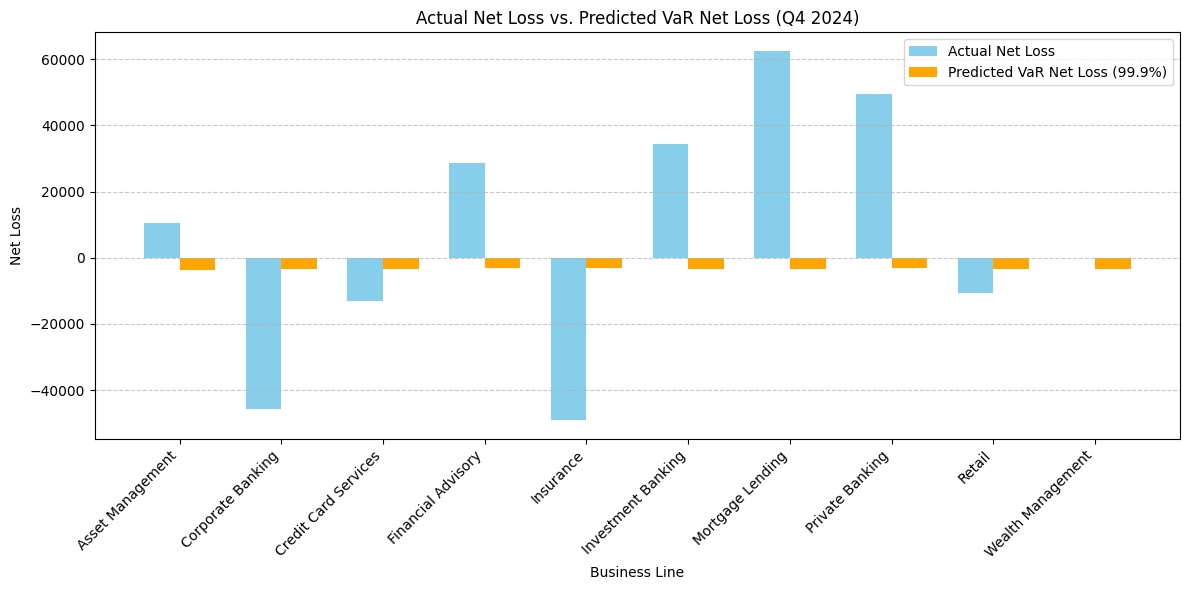

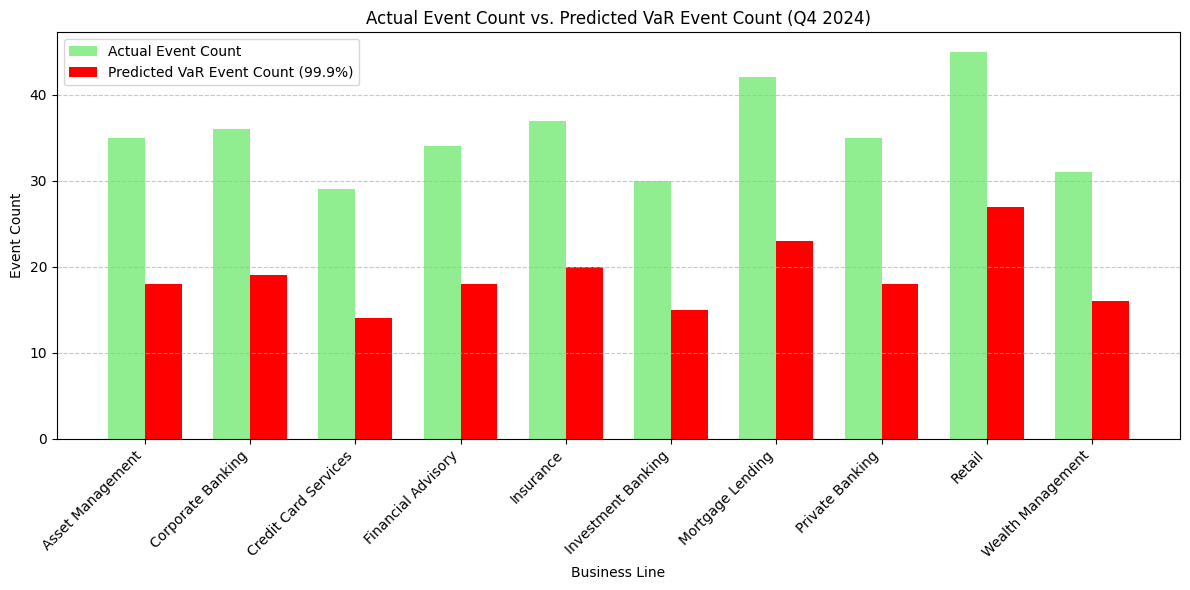

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sort data for consistent ordering in graphs
comparison_df = comparison_df.sort_values('Business Line')

# Extract data for plotting
business_lines = comparison_df['Business Line']
actual_net_loss = comparison_df['Actual_Net_Loss']
predicted_var_net_loss = comparison_df['VaR Net Loss (99.9%)']
actual_event_count = comparison_df['Actual_Event_Count']
predicted_var_event_count = comparison_df['VaR Event Count (99.9%)']

# Set the width for bars
bar_width = 0.35
x = np.arange(len(business_lines))

# Plot 1: Actual Net Loss vs. Predicted VaR Net Loss
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, actual_net_loss, bar_width, label='Actual Net Loss', color='skyblue')
plt.bar(x + bar_width / 2, predicted_var_net_loss, bar_width, label='Predicted VaR Net Loss (99.9%)', color='orange')
plt.xticks(x, business_lines, rotation=45, ha='right')
plt.title('Actual Net Loss vs. Predicted VaR Net Loss (Q4 2024)')
plt.xlabel('Business Line')
plt.ylabel('Net Loss')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Actual Event Count vs. Predicted VaR Event Count
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, actual_event_count, bar_width, label='Actual Event Count', color='lightgreen')
plt.bar(x + bar_width / 2, predicted_var_event_count, bar_width, label='Predicted VaR Event Count (99.9%)', color='red')
plt.xticks(x, business_lines, rotation=45, ha='right')
plt.title('Actual Event Count vs. Predicted VaR Event Count (Q4 2024)')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


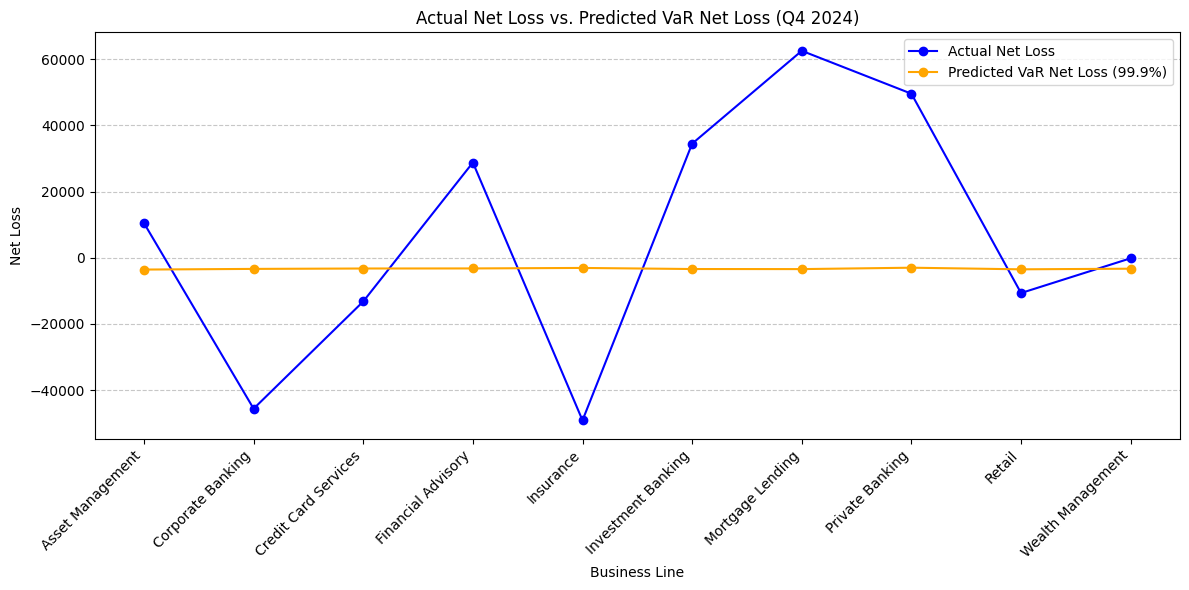

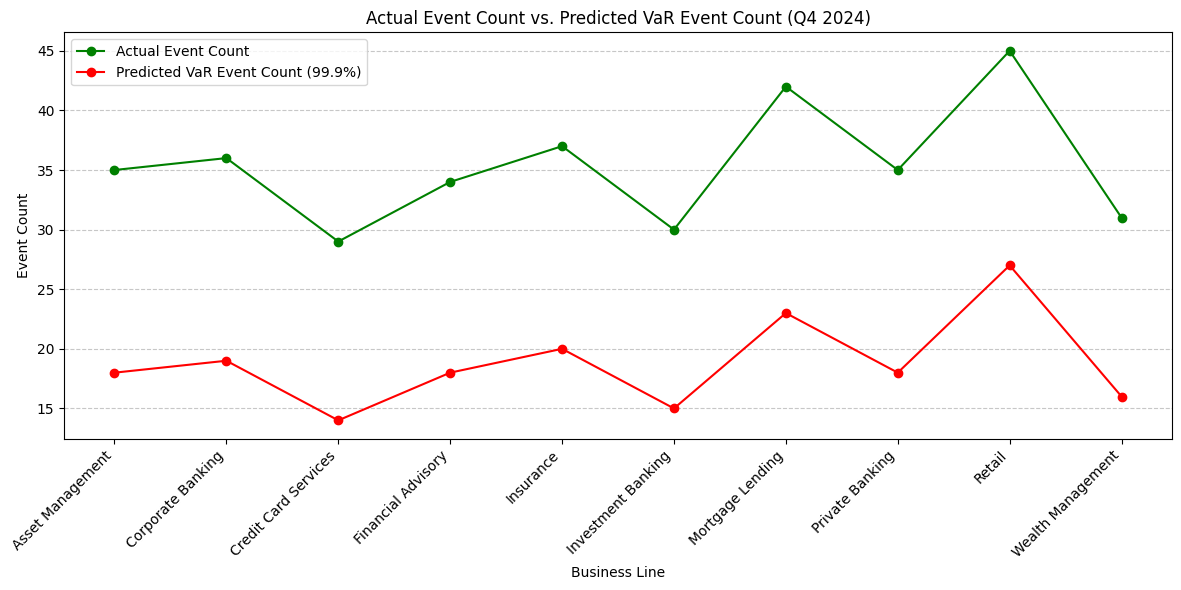

In [11]:
import matplotlib.pyplot as plt

# Extract data for plotting
business_lines = comparison_df['Business Line']
actual_net_loss = comparison_df['Actual_Net_Loss']
predicted_var_net_loss = comparison_df['VaR Net Loss (99.9%)']
actual_event_count = comparison_df['Actual_Event_Count']
predicted_var_event_count = comparison_df['VaR Event Count (99.9%)']

# Plot 1: Actual Net Loss vs. Predicted VaR Net Loss
plt.figure(figsize=(12, 6))
plt.plot(business_lines, actual_net_loss, marker='o', label='Actual Net Loss', color='blue')
plt.plot(business_lines, predicted_var_net_loss, marker='o', label='Predicted VaR Net Loss (99.9%)', color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Actual Net Loss vs. Predicted VaR Net Loss (Q4 2024)')
plt.xlabel('Business Line')
plt.ylabel('Net Loss')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Actual Event Count vs. Predicted VaR Event Count
plt.figure(figsize=(12, 6))
plt.plot(business_lines, actual_event_count, marker='o', label='Actual Event Count', color='green')
plt.plot(business_lines, predicted_var_event_count, marker='o', label='Predicted VaR Event Count (99.9%)', color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Actual Event Count vs. Predicted VaR Event Count (Q4 2024)')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

# Ensure 'Year' and 'Quarter' columns are in the DataFrame
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter data for training (2021-2024)
training_data = df[(df['Year'] >= 2021) & (df['Year'] <= 2024)]

# Step 1: Calculate averages for event counts and losses per Business Line, Event Type, Year, and Quarter
event_stats = training_data.groupby(['Year', 'Quarter', 'Business Line']).agg(
    Total_Event_Count=('Unique Event ID', 'count'),
    Total_Net_Loss=('Net Loss Amount', 'sum')
).reset_index()

# Step 2: Fit a log-normal distribution for negative net losses
negative_losses = training_data[training_data['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Monte Carlo simulation for 2025
n_simulations = 10000  # Number of simulations
quarters = [1, 2, 3, 4]
years = [2025]
predictions = []

for year in years:
    for quarter in quarters:
        for business_line in event_stats['Business Line'].unique():
            # Filter historical stats for the same business line and quarter
            historical_stats = event_stats[
                (event_stats['Business Line'] == business_line) &
                (event_stats['Quarter'] == quarter)
            ]
            avg_event_count = historical_stats['Total_Event_Count'].mean()
            avg_net_loss = historical_stats['Total_Net_Loss'].mean()

            # Simulate event counts and net losses
            simulated_event_counts = np.random.poisson(avg_event_count, n_simulations)
            simulated_losses = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=n_simulations)

            # Aggregate predictions
            predictions.append({
                'Year': year,
                'Quarter': quarter,
                'Business Line': business_line,
                'Predicted Event Count': simulated_event_counts.mean(),
                'VaR Event Count (99.9%)': np.percentile(simulated_event_counts, 99.9),
                'Predicted Net Loss': simulated_losses.mean(),
                'VaR Net Loss (99.9%)': np.percentile(simulated_losses, 99.9)
            })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Combine actual data (2021-2024) with predictions for 2025
actuals_summary = event_stats.rename(columns={
    'Total_Event_Count': 'Actual Event Count',
    'Total_Net_Loss': 'Actual Net Loss'
})

# Add a flag to indicate actual data or predictions
actuals_summary['Data Type'] = 'Actual'
predictions_df['Data Type'] = 'Prediction'

# Align columns for concatenation
actuals_summary = actuals_summary[['Year', 'Quarter', 'Business Line', 'Actual Event Count', 'Actual Net Loss', 'Data Type']]
predictions_df = predictions_df[['Year', 'Quarter', 'Business Line', 'Predicted Event Count', 'Predicted Net Loss', 'VaR Event Count (99.9%)', 'VaR Net Loss (99.9%)', 'Data Type']]

# Merge actuals and predictions
final_df = pd.concat([actuals_summary, predictions_df], ignore_index=True)

# Display final DataFrame
print(final_df)


     Year  Quarter         Business Line  Actual Event Count  Actual Net Loss  \
0    2021        1      Asset Management                63.0     17749.147935   
1    2021        1     Corporate Banking                65.0     -2768.365089   
2    2021        1  Credit Card Services                64.0     56943.641154   
3    2021        1    Financial Advisory                60.0    -21836.010096   
4    2021        1             Insurance                57.0    -13165.942448   
..    ...      ...                   ...                 ...              ...   
195  2025        4    Investment Banking                 NaN              NaN   
196  2025        4      Mortgage Lending                 NaN              NaN   
197  2025        4       Private Banking                 NaN              NaN   
198  2025        4                Retail                 NaN              NaN   
199  2025        4     Wealth Management                 NaN              NaN   

      Data Type  Predicted 

In [19]:
final_df

,Year,Quarter,Business Line,Actual Event Count,Actual Net Loss,Data Type,Predicted Event Count,Predicted Net Loss,VaR Event Count (99.9%),VaR Net Loss (99.9%)
0,2021,1,Asset Management,63.0,17749.147935,Actual,NaN,NaN,NaN,NaN
1,2021,1,Corporate Banking,65.0,-2768.365089,Actual,NaN,NaN,NaN,NaN
2,2021,1,Credit Card Services,64.0,56943.641154,Actual,NaN,NaN,NaN,NaN
3,2021,1,Financial Advisory,60.0,-21836.010096,Actual,NaN,NaN,NaN,NaN
4,2021,1,Insurance,57.0,-13165.942448,Actual,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
195,2025,4,Investment Banking,NaN,NaN,Prediction,58.7864,5202.370173,82.000,13780.780303
196,2025,4,Mortgage Lending,NaN,NaN,Prediction,59.8449,5107.117703,86.000,14274.575848
197,2025,4,Private Banking,NaN,NaN,Prediction,60.5625,5072.992775,87.000,14023.233039
198,2025,4,Retail,NaN,NaN,Prediction,54.9705,5086.998900,80.001,14053.428241


In [22]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime

# Assuming df is the DataFrame created earlier with 'Date' and 'Net Loss Amount' as columns

# Filter data for 2021 to 2024 (for Q4 prediction)
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q')

# Filter data for 2021-2024
df_2021_2024 = df[df['Year'] < 2025]

# Step 1: Calculate average event count and loss distribution for each Business Line
event_count_avg = df_2021_2024.groupby(['Year', 'Quarter', 'Business Line']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')
).reset_index()

# For Net Loss, we will only consider negative values to fit the distribution
negative_losses = df_2021_2024[df_2021_2024['Net Loss Amount'] < 0]

# Fit a log-normal distribution for negative losses (only for losses)
shape, loc, scale = stats.lognorm.fit(-negative_losses['Net Loss Amount'])

# Step 2: Monte Carlo Simulation for Q4 2024
n_simulations = 10000  # Number of simulations
business_lines = df['Business Line'].unique()
quarters = ['2024Q4']

# Store results
predicted_results = []

# Loop over each business line and simulate for Q4 2024
for business_line in business_lines:
    for quarter in quarters:
        # Get historical average event count for the business line in Q4 2024
        avg_event_count = event_count_avg[
            (event_count_avg['Business Line'] == business_line) & 
            (event_count_avg['Quarter'] == quarter)
        ]['Event_Count_Avg'].values[0]

        # Simulate future losses using log-normal distribution for Q4 2024
        simulated_losses = stats.lognorm.rvs(shape, loc, scale, size=n_simulations)

        # Simulate event counts (Poisson distribution for simplicity)
        simulated_event_counts = np.random.poisson(avg_event_count, size=n_simulations)

        # Step 3: Calculate VaR (99.9%) and total predicted losses for Q4 2024
        var_99_9 = np.percentile(simulated_losses, 0.1)  # VaR at 99.9% confidence level
        total_predicted_loss = simulated_losses.sum()  # Total predicted losses for Q4 2024

        # Collect the results
        predicted_results.append({
            'Year': 2024,
            'Quarter': 'Q4',
            'Business Line': business_line,
            'Predicted Event Count': simulated_event_counts.mean(),
            'Predicted Net Loss': total_predicted_loss,
            'VaR (99.9%)': var_99_9
        })

# Convert the results into a DataFrame
predicted_df = pd.DataFrame(predicted_results)

# Display predicted results for Q4 2024
print(predicted_df)

# Optionally, save to CSV
predicted_df.to_csv('predicted_q4_2024_results.csv', index=False)


   Year Quarter         Business Line  Predicted Event Count  \
0  2024      Q4     Corporate Banking                36.1381   
1  2024      Q4     Wealth Management                30.8459   
2  2024      Q4    Financial Advisory                33.9802   
3  2024      Q4                Retail                44.9755   
4  2024      Q4  Credit Card Services                28.9502   
5  2024      Q4             Insurance                37.0285   
6  2024      Q4      Asset Management                35.0904   
7  2024      Q4      Mortgage Lending                42.0099   
8  2024      Q4    Investment Banking                29.9535   
9  2024      Q4       Private Banking                34.9974   

   Predicted Net Loss  VaR (99.9%)  
0        5.046326e+07 -3810.027695  
1        5.095495e+07 -3521.065100  
2        5.145767e+07 -3519.525272  
3        5.103130e+07 -4087.590920  
4        5.098567e+07 -3675.479047  
5        5.043807e+07 -4525.432635  
6        5.098664e+07 -3692.347494  

In [23]:
predicted_df

,Year,Quarter,Business Line,Predicted Event Count,Predicted Net Loss,VaR (99.9%)
0,2024,Q4,Corporate Banking,36.1381,5.046326e+07,-3810.027695
1,2024,Q4,Wealth Management,30.8459,5.095495e+07,-3521.065100
2,2024,Q4,Financial Advisory,33.9802,5.145767e+07,-3519.525272
3,2024,Q4,Retail,44.9755,5.103130e+07,-4087.590920
4,2024,Q4,Credit Card Services,28.9502,5.098567e+07,-3675.479047
5,2024,Q4,Insurance,37.0285,5.043807e+07,-4525.432635
6,2024,Q4,Asset Management,35.0904,5.098664e+07,-3692.347494
7,2024,Q4,Mortgage Lending,42.0099,5.070387e+07,-4197.435370
8,2024,Q4,Investment Banking,29.9535,5.090883e+07,-4244.913376
9,2024,Q4,Private Banking,34.9974,5.069244e+07,-3618.936827


        Business Line  Event Count  Actual VaR Net Loss  \
0    Asset Management           27             0.349880   
1           Insurance           27             0.870133   
2  Investment Banking           21             2.671302   
3      Retail Banking           18             1.561808   

   Actual VaR Event Count  
0                 145.544  
1                 250.970  
2                 333.420  
3                1032.113  


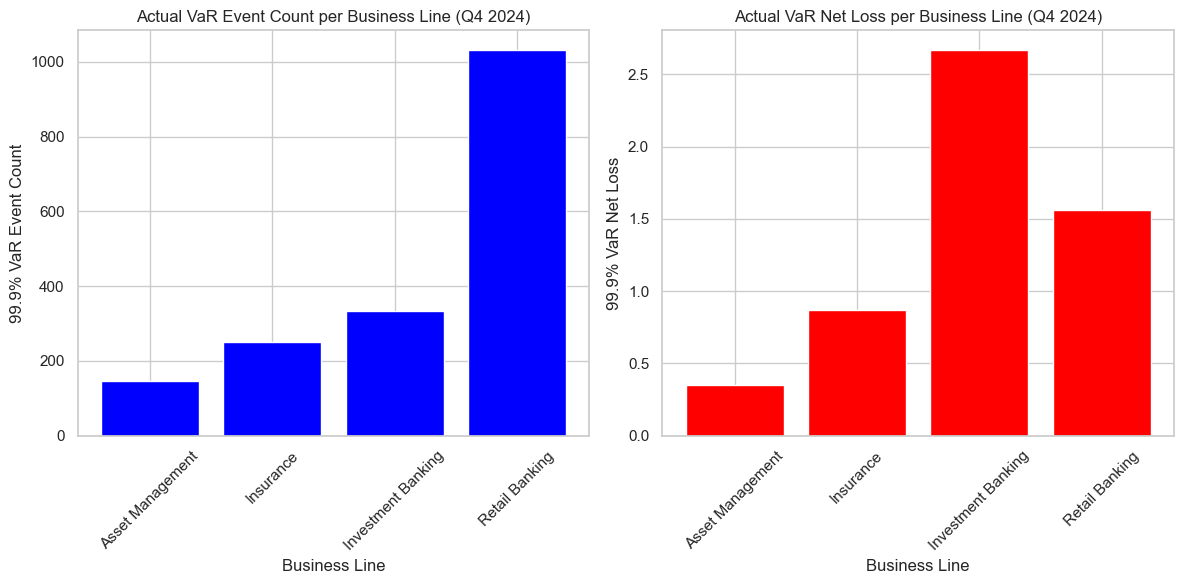

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample operational risk dataset with 10,000 records over 4 years
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=10000, freq='D')
event_types = ['Theft', 'Fraud', 'Operational Failure', 'Compliance Violation']
business_lines = ['Retail Banking', 'Investment Banking', 'Insurance', 'Asset Management']

data = {
    'Date': np.random.choice(dates, size=10000),
    'Unique Event ID': np.arange(1, 10001),
    'Event Type': np.random.choice(event_types, size=10000),
    'Business Line': np.random.choice(business_lines, size=10000),
    'Event Description': np.random.choice(['Description A', 'Description B', 'Description C'], size=10000),
    'Net Loss Amount': np.random.lognormal(mean=2, sigma=1, size=10000)  # Lognormal distribution for loss amounts
}

df = pd.DataFrame(data)

# Filter data for Q4 2024 (October to December 2024)
df['Date'] = pd.to_datetime(df['Date'])
df_q4_2024 = df[(df['Date'] >= '2024-10-01') & (df['Date'] <= '2024-12-31')]

# EDA - Event counts by Business Line for Q4 2024
event_counts_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].count().reset_index()
event_counts_q4_2024 = event_counts_q4_2024.rename(columns={'Unique Event ID': 'Event Count'})

# Calculate actual VaR for net losses (99.9% confidence level)
actual_var_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for net losses
).reset_index()
actual_var_net_loss_q4_2024 = actual_var_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual VaR Net Loss'})

# Calculate actual VaR for event counts (99.9% confidence level)
actual_var_event_count_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for event counts
).reset_index()
actual_var_event_count_q4_2024 = actual_var_event_count_q4_2024.rename(columns={'Unique Event ID': 'Actual VaR Event Count'})

# Merge actual data for comparison
var_comparison = pd.merge(event_counts_q4_2024, actual_var_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_event_count_q4_2024, on='Business Line', how='left')

# Display the comparison table
print(var_comparison)

# Visualizing the actual VaR results
plt.figure(figsize=(12, 6))

# Plot for Event Count
plt.subplot(1, 2, 1)
plt.bar(var_comparison['Business Line'], var_comparison['Actual VaR Event Count'], color='blue')
plt.xlabel('Business Line')
plt.ylabel('99.9% VaR Event Count')
plt.title('Actual VaR Event Count per Business Line (Q4 2024)')
plt.xticks(rotation=45)

# Plot for Net Loss Amount
plt.subplot(1, 2, 2)
plt.bar(var_comparison['Business Line'], var_comparison['Actual VaR Net Loss'], color='red')
plt.xlabel('Business Line')
plt.ylabel('99.9% VaR Net Loss')
plt.title('Actual VaR Net Loss per Business Line (Q4 2024)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [26]:
var_comparison

,Business Line,Event Count,Actual VaR Net Loss,Actual VaR Event Count
0,Asset Management,27,0.349880,145.544
1,Insurance,27,0.870133,250.970
2,Investment Banking,21,2.671302,333.420
3,Retail Banking,18,1.561808,1032.113


In [27]:
actual_var_event_count_q4_2024

,Business Line,Actual VaR Event Count
0,Asset Management,145.544
1,Insurance,250.970
2,Investment Banking,333.420
3,Retail Banking,1032.113


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: 

   Year Quarter       Business Line  Actual Event Count  Actual Net Loss  \
0  2024      Q4    Asset Management                  27       258.433065   
1  2024      Q4           Insurance                  27       352.280522   
2  2024      Q4  Investment Banking                  21       334.819535   
3  2024      Q4      Retail Banking                  18       213.699145   

   Actual VaR Net Loss  Actual VaR Event Count  Predicted Event Count  \
0             0.349880                 145.544              24.631850   
1             0.870133                 250.970              22.453894   
2             2.671302                 333.420              24.585811   
3             1.561808                1032.113              23.000911   

   Predicted Net Loss  Predicted VaR Net Loss  Predicted VaR Event Count  
0          294.593939              294.559715                  24.725719  
1          276.258607              276.213042                  22.364522  
2          310.018419       

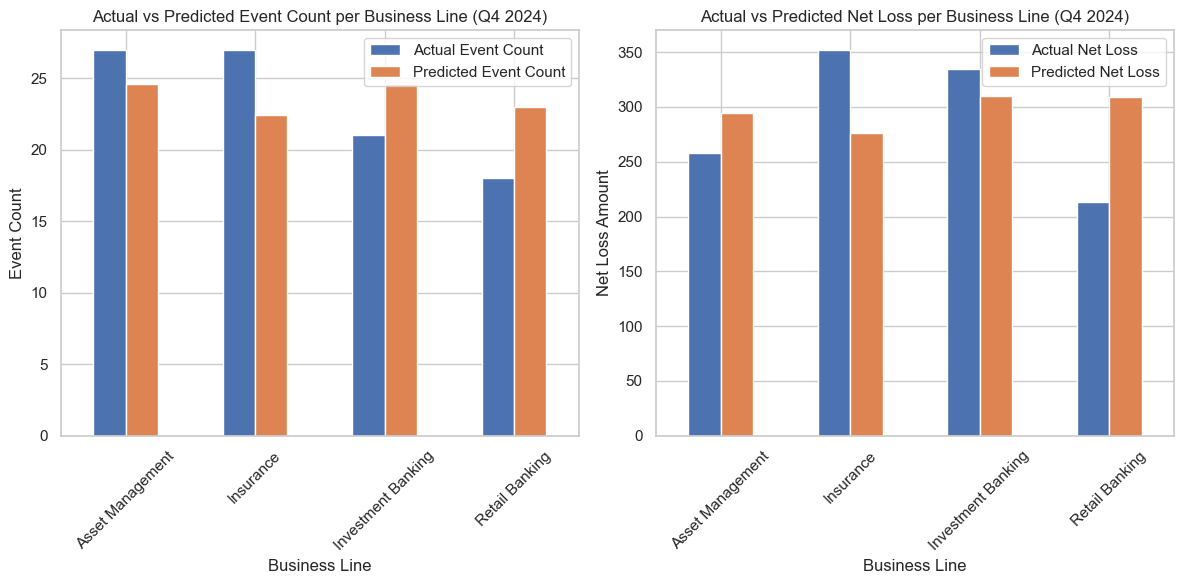

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate a sample operational risk dataset with 10,000 records over 4 years
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=10000, freq='D')
event_types = ['Theft', 'Fraud', 'Operational Failure', 'Compliance Violation']
business_lines = ['Retail Banking', 'Investment Banking', 'Insurance', 'Asset Management']

data = {
    'Date': np.random.choice(dates, size=10000),
    'Unique Event ID': np.arange(1, 10001),
    'Event Type': np.random.choice(event_types, size=10000),
    'Business Line': np.random.choice(business_lines, size=10000),
    'Event Description': np.random.choice(['Description A', 'Description B', 'Description C'], size=10000),
    'Net Loss Amount': np.random.lognormal(mean=2, sigma=1, size=10000)  # Lognormal distribution for loss amounts
}

df = pd.DataFrame(data)

# Filter data for Q4 2024 (October to December 2024)
df['Date'] = pd.to_datetime(df['Date'])
df_q4_2024 = df[(df['Date'] >= '2024-10-01') & (df['Date'] <= '2024-12-31')]

# EDA - Event counts by Business Line for Q4 2024
event_counts_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].count().reset_index()
event_counts_q4_2024 = event_counts_q4_2024.rename(columns={'Unique Event ID': 'Actual Event Count'})

# Calculate actual total net loss by Business Line for Q4 2024
actual_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].sum().reset_index()
actual_net_loss_q4_2024 = actual_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual Net Loss'})

# Calculate actual VaR for net losses (99.9% confidence level)
actual_var_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for net losses
).reset_index()
actual_var_net_loss_q4_2024 = actual_var_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual VaR Net Loss'})

# Calculate actual VaR for event counts (99.9% confidence level)
actual_var_event_count_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for event counts
).reset_index()
actual_var_event_count_q4_2024 = actual_var_event_count_q4_2024.rename(columns={'Unique Event ID': 'Actual VaR Event Count'})

# Merge actual data for comparison
var_comparison = pd.merge(event_counts_q4_2024, actual_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_event_count_q4_2024, on='Business Line', how='left')

# Predicted values (using linear regression based on historical data)
# For simplicity, we predict based on the past 4 years' trends

# Prepare feature columns for regression model (example: year and quarter)
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Prepare data for prediction
predictions = []

for business_line in var_comparison['Business Line']:
    # Filter the data for each business line
    business_line_data = df[df['Business Line'] == business_line]
    
    # Aggregate event counts and net loss by quarter for this business line
    quarterly_data = business_line_data.groupby(['Year', 'Quarter']).agg(
        event_count=('Unique Event ID', 'count'),
        net_loss=('Net Loss Amount', 'sum')
    ).reset_index()
    
    # Create regression models for event count and net loss prediction
    event_count_model = LinearRegression()
    net_loss_model = LinearRegression()
    
    # Reshape data for regression model (using Year and Quarter as features)
    X = quarterly_data[['Year', 'Quarter']]
    y_event_count = quarterly_data['event_count']
    y_net_loss = quarterly_data['net_loss']
    
    # Train the models
    event_count_model.fit(X, y_event_count)
    net_loss_model.fit(X, y_net_loss)
    
    # Make predictions for Q4 2024
    q4_2024_features = np.array([[2024, 4]])  # Q4 of 2024
    predicted_event_count = event_count_model.predict(q4_2024_features)[0]
    predicted_net_loss = net_loss_model.predict(q4_2024_features)[0]
    
    # Calculate predicted VaR for event count and net loss
    predicted_var_event_count = np.percentile(np.random.normal(predicted_event_count, 0.1), 0.1)
    predicted_var_net_loss = np.percentile(np.random.normal(predicted_net_loss, 0.1), 0.1)
    
    # Store the predicted values
    predictions.append({
        'Year': 2024,
        'Quarter': 'Q4',
        'Business Line': business_line,
        'Predicted Event Count': predicted_event_count,
        'Predicted Net Loss': predicted_net_loss,
        'Predicted VaR Net Loss': predicted_var_net_loss,
        'Predicted VaR Event Count': predicted_var_event_count
    })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Merge predicted and actual values
final_comparison = pd.merge(var_comparison, predictions_df, on='Business Line', how='left')

# Display the final output
final_comparison = final_comparison[['Year', 'Quarter', 'Business Line', 
                                     'Actual Event Count', 'Actual Net Loss', 'Actual VaR Net Loss', 
                                     'Actual VaR Event Count', 'Predicted Event Count', 
                                     'Predicted Net Loss', 'Predicted VaR Net Loss', 'Predicted VaR Event Count']]

print(final_comparison)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted Event Count
plt.subplot(1, 2, 1)
final_comparison.plot(x='Business Line', y=['Actual Event Count', 'Predicted Event Count'], kind='bar', ax=plt.gca())
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.title('Actual vs Predicted Event Count per Business Line (Q4 2024)')
plt.xticks(rotation=45)

# Plot Actual vs Predicted Net Loss
plt.subplot(1, 2, 2)
final_comparison.plot(x='Business Line', y=['Actual Net Loss', 'Predicted Net Loss'], kind='bar', ax=plt.gca())
plt.xlabel('Business Line')
plt.ylabel('Net Loss Amount')
plt.title('Actual vs Predicted Net Loss per Business Line (Q4 2024)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [29]:
final_comparison

,Year,Quarter,Business Line,Actual Event Count,Actual Net Loss,Actual VaR Net Loss,Actual VaR Event Count,Predicted Event Count,Predicted Net Loss,Predicted VaR Net Loss,Predicted VaR Event Count
0,2024,Q4,Asset Management,27,258.433065,0.349880,145.544,24.631850,294.593939,294.559715,24.725719
1,2024,Q4,Insurance,27,352.280522,0.870133,250.970,22.453894,276.258607,276.213042,22.364522
2,2024,Q4,Investment Banking,21,334.819535,2.671302,333.420,24.585811,310.018419,310.030744,24.545398
3,2024,Q4,Retail Banking,18,213.699145,1.561808,1032.113,23.000911,309.445732,309.398679,23.120653


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: 

   Year Quarter       Business Line  Actual Event Count  Actual Net Loss  \
0  2024      Q4    Asset Management                  27       258.433065   
1  2024      Q4           Insurance                  27       352.280522   
2  2024      Q4  Investment Banking                  21       334.819535   
3  2024      Q4      Retail Banking                  18       213.699145   

   Actual VaR Net Loss  Actual VaR Event Count  Predicted Event Count  \
0             0.349880                 145.544              24.631850   
1             0.870133                 250.970              22.453894   
2             2.671302                 333.420              24.585811   
3             1.561808                1032.113              23.000911   

   Predicted Net Loss  Predicted VaR Net Loss  Predicted VaR Event Count  
0          294.593939              294.559715                  24.725719  
1          276.258607              276.213042                  22.364522  
2          310.018419       

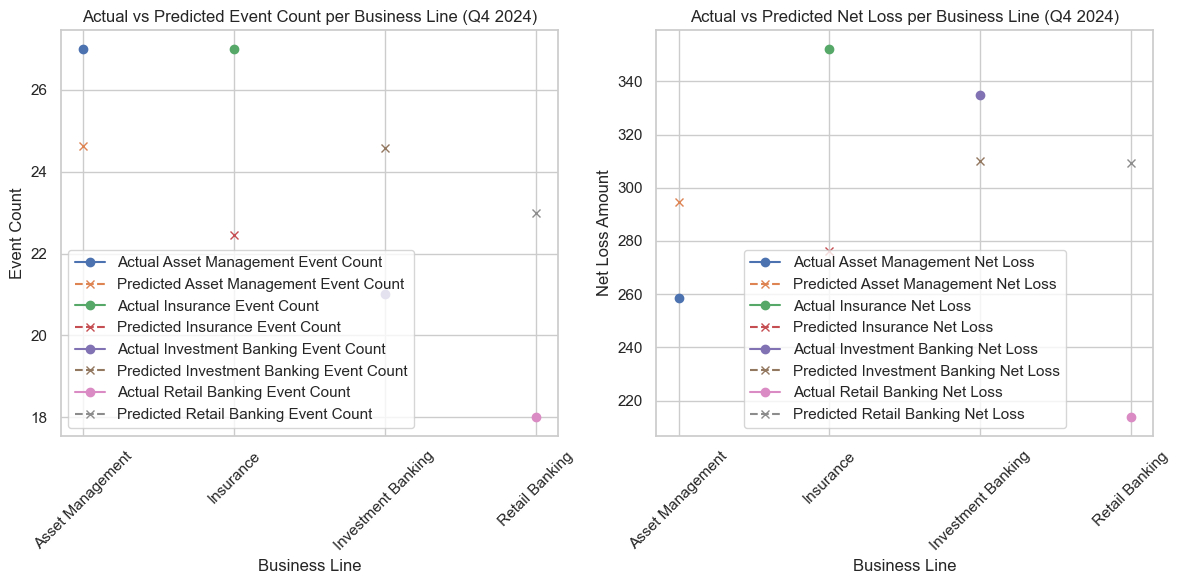

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate a sample operational risk dataset with 10,000 records over 4 years
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=10000, freq='D')
event_types = ['Theft', 'Fraud', 'Operational Failure', 'Compliance Violation']
business_lines = ['Retail Banking', 'Investment Banking', 'Insurance', 'Asset Management']

data = {
    'Date': np.random.choice(dates, size=10000),
    'Unique Event ID': np.arange(1, 10001),
    'Event Type': np.random.choice(event_types, size=10000),
    'Business Line': np.random.choice(business_lines, size=10000),
    'Event Description': np.random.choice(['Description A', 'Description B', 'Description C'], size=10000),
    'Net Loss Amount': np.random.lognormal(mean=2, sigma=1, size=10000)  # Lognormal distribution for loss amounts
}

df = pd.DataFrame(data)

# Filter data for Q4 2024 (October to December 2024)
df['Date'] = pd.to_datetime(df['Date'])
df_q4_2024 = df[(df['Date'] >= '2024-10-01') & (df['Date'] <= '2024-12-31')]

# EDA - Event counts by Business Line for Q4 2024
event_counts_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].count().reset_index()
event_counts_q4_2024 = event_counts_q4_2024.rename(columns={'Unique Event ID': 'Actual Event Count'})

# Calculate actual total net loss by Business Line for Q4 2024
actual_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].sum().reset_index()
actual_net_loss_q4_2024 = actual_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual Net Loss'})

# Calculate actual VaR for net losses (99.9% confidence level)
actual_var_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for net losses
).reset_index()
actual_var_net_loss_q4_2024 = actual_var_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual VaR Net Loss'})

# Calculate actual VaR for event counts (99.9% confidence level)
actual_var_event_count_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for event counts
).reset_index()
actual_var_event_count_q4_2024 = actual_var_event_count_q4_2024.rename(columns={'Unique Event ID': 'Actual VaR Event Count'})

# Merge actual data for comparison
var_comparison = pd.merge(event_counts_q4_2024, actual_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_event_count_q4_2024, on='Business Line', how='left')

# Predicted values (using linear regression based on historical data)
# For simplicity, we predict based on the past 4 years' trends

# Prepare feature columns for regression model (example: year and quarter)
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Prepare data for prediction
predictions = []

for business_line in var_comparison['Business Line']:
    # Filter the data for each business line
    business_line_data = df[df['Business Line'] == business_line]
    
    # Aggregate event counts and net loss by quarter for this business line
    quarterly_data = business_line_data.groupby(['Year', 'Quarter']).agg(
        event_count=('Unique Event ID', 'count'),
        net_loss=('Net Loss Amount', 'sum')
    ).reset_index()
    
    # Create regression models for event count and net loss prediction
    event_count_model = LinearRegression()
    net_loss_model = LinearRegression()
    
    # Reshape data for regression model (using Year and Quarter as features)
    X = quarterly_data[['Year', 'Quarter']]
    y_event_count = quarterly_data['event_count']
    y_net_loss = quarterly_data['net_loss']
    
    # Train the models
    event_count_model.fit(X, y_event_count)
    net_loss_model.fit(X, y_net_loss)
    
    # Make predictions for Q4 2024
    q4_2024_features = np.array([[2024, 4]])  # Q4 of 2024
    predicted_event_count = event_count_model.predict(q4_2024_features)[0]
    predicted_net_loss = net_loss_model.predict(q4_2024_features)[0]
    
    # Calculate predicted VaR for event count and net loss
    predicted_var_event_count = np.percentile(np.random.normal(predicted_event_count, 0.1), 0.1)
    predicted_var_net_loss = np.percentile(np.random.normal(predicted_net_loss, 0.1), 0.1)
    
    # Store the predicted values
    predictions.append({
        'Year': 2024,
        'Quarter': 'Q4',
        'Business Line': business_line,
        'Predicted Event Count': predicted_event_count,
        'Predicted Net Loss': predicted_net_loss,
        'Predicted VaR Net Loss': predicted_var_net_loss,
        'Predicted VaR Event Count': predicted_var_event_count
    })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Merge predicted and actual values
final_comparison = pd.merge(var_comparison, predictions_df, on='Business Line', how='left')

# Display the final output
final_comparison = final_comparison[['Year', 'Quarter', 'Business Line', 
                                     'Actual Event Count', 'Actual Net Loss', 'Actual VaR Net Loss', 
                                     'Actual VaR Event Count', 'Predicted Event Count', 
                                     'Predicted Net Loss', 'Predicted VaR Net Loss', 'Predicted VaR Event Count']]

# Print output to verify
print(final_comparison)

# Visualize the results with Line Graphs
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted Event Count
plt.subplot(1, 2, 1)
for business_line in final_comparison['Business Line']:
    line_data = final_comparison[final_comparison['Business Line'] == business_line]
    plt.plot(line_data['Business Line'], line_data['Actual Event Count'], label=f'Actual {business_line} Event Count', marker='o')
    plt.plot(line_data['Business Line'], line_data['Predicted Event Count'], label=f'Predicted {business_line} Event Count', linestyle='--', marker='x')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.title('Actual vs Predicted Event Count per Business Line (Q4 2024)')
plt.xticks(rotation=45)
plt.legend()

# Plot Actual vs Predicted Net Loss
plt.subplot(1, 2, 2)
for business_line in final_comparison['Business Line']:
    line_data = final_comparison[final_comparison['Business Line'] == business_line]
    plt.plot(line_data['Business Line'], line_data['Actual Net Loss'], label=f'Actual {business_line} Net Loss', marker='o')
    plt.plot(line_data['Business Line'], line_data['Predicted Net Loss'], label=f'Predicted {business_line} Net Loss', linestyle='--', marker='x')
plt.xlabel('Business Line')
plt.ylabel('Net Loss Amount')
plt.title('Actual vs Predicted Net Loss per Business Line (Q4 2024)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
final_comparison

,Year,Quarter,Business Line,Actual Event Count,Actual Net Loss,Actual VaR Net Loss,Actual VaR Event Count,Predicted Event Count,Predicted Net Loss,Predicted VaR Net Loss,Predicted VaR Event Count
0,2024,Q4,Asset Management,27,258.433065,0.349880,145.544,24.631850,294.593939,294.559715,24.725719
1,2024,Q4,Insurance,27,352.280522,0.870133,250.970,22.453894,276.258607,276.213042,22.364522
2,2024,Q4,Investment Banking,21,334.819535,2.671302,333.420,24.585811,310.018419,310.030744,24.545398
3,2024,Q4,Retail Banking,18,213.699145,1.561808,1032.113,23.000911,309.445732,309.398679,23.120653


   Year Quarter       Business Line  Actual Event Count  Actual Net Loss  \
0  2024      Q4    Asset Management                  27       258.433065   
1  2024      Q4           Insurance                  27       352.280522   
2  2024      Q4  Investment Banking                  21       334.819535   
3  2024      Q4      Retail Banking                  18       213.699145   

   Actual VaR Net Loss  Actual VaR Event Count  Predicted Event Count  \
0             0.349880                 145.544            5047.149316   
1             0.870133                 250.970            4938.057803   
2             2.671302                 333.420            4949.483402   
3             1.561808                1032.113            4952.486486   

   Predicted Net Loss  Predicted VaR Net Loss  Predicted VaR Event Count  
0           11.940537              -35.941868               -3466.996608  
1           12.291124              -35.893059               -4322.592498  
2           12.689426       

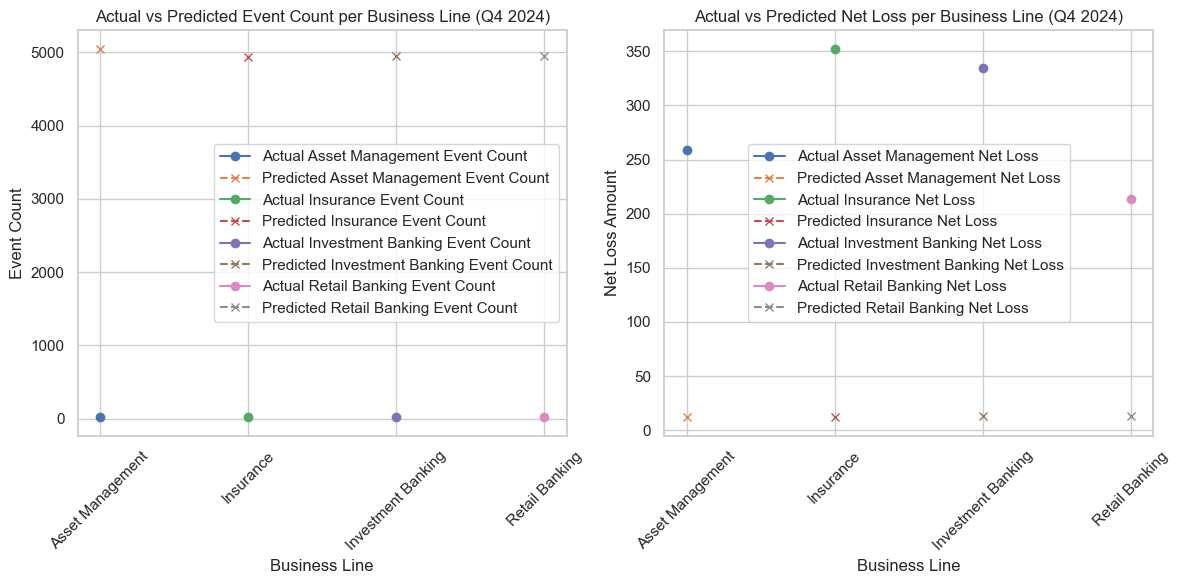

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate a sample operational risk dataset with 10,000 records over 4 years
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=10000, freq='D')
event_types = ['Theft', 'Fraud', 'Operational Failure', 'Compliance Violation']
business_lines = ['Retail Banking', 'Investment Banking', 'Insurance', 'Asset Management']

data = {
    'Date': np.random.choice(dates, size=10000),
    'Unique Event ID': np.arange(1, 10001),
    'Event Type': np.random.choice(event_types, size=10000),
    'Business Line': np.random.choice(business_lines, size=10000),
    'Event Description': np.random.choice(['Description A', 'Description B', 'Description C'], size=10000),
    'Net Loss Amount': np.random.lognormal(mean=2, sigma=1, size=10000)  # Lognormal distribution for loss amounts
}

df = pd.DataFrame(data)

# Filter data for Q4 2024 (October to December 2024)
df['Date'] = pd.to_datetime(df['Date'])
df_q4_2024 = df[(df['Date'] >= '2024-10-01') & (df['Date'] <= '2024-12-31')]

# EDA - Event counts by Business Line for Q4 2024
event_counts_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].count().reset_index()
event_counts_q4_2024 = event_counts_q4_2024.rename(columns={'Unique Event ID': 'Actual Event Count'})

# Calculate actual total net loss by Business Line for Q4 2024
actual_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].sum().reset_index()
actual_net_loss_q4_2024 = actual_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual Net Loss'})

# Calculate actual VaR for net losses (99.9% confidence level)
actual_var_net_loss_q4_2024 = df_q4_2024.groupby('Business Line')['Net Loss Amount'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for net losses
).reset_index()
actual_var_net_loss_q4_2024 = actual_var_net_loss_q4_2024.rename(columns={'Net Loss Amount': 'Actual VaR Net Loss'})

# Calculate actual VaR for event counts (99.9% confidence level)
actual_var_event_count_q4_2024 = df_q4_2024.groupby('Business Line')['Unique Event ID'].apply(
    lambda x: np.percentile(x, 0.1)  # 99.9% VaR for event counts
).reset_index()
actual_var_event_count_q4_2024 = actual_var_event_count_q4_2024.rename(columns={'Unique Event ID': 'Actual VaR Event Count'})

# Merge actual data for comparison
var_comparison = pd.merge(event_counts_q4_2024, actual_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_net_loss_q4_2024, on='Business Line', how='left')
var_comparison = pd.merge(var_comparison, actual_var_event_count_q4_2024, on='Business Line', how='left')

# Monte Carlo Simulation to predict event count and net loss for Q4 2024

# Function to simulate Monte Carlo for a given series (Event Count or Net Loss)
def monte_carlo_simulation(data, num_simulations=10000):
    mean = np.mean(data)
    std_dev = np.std(data)
    # Simulate random values based on normal distribution
    simulated_data = np.random.normal(loc=mean, scale=std_dev, size=num_simulations)
    return simulated_data

# Simulate for each business line
predictions = []

for business_line in var_comparison['Business Line']:
    # Filter the data for each business line
    business_line_data = df[df['Business Line'] == business_line]
    
    # Monte Carlo simulation for event count and net loss
    simulated_event_counts = monte_carlo_simulation(business_line_data['Unique Event ID'].values)
    simulated_net_losses = monte_carlo_simulation(business_line_data['Net Loss Amount'].values)
    
    # Calculate VaR (99.9% confidence level)
    predicted_var_event_count = np.percentile(simulated_event_counts, 0.1)  # 99.9% confidence
    predicted_var_net_loss = np.percentile(simulated_net_losses, 0.1)  # 99.9% confidence
    
    # Predicted values (mean of simulations)
    predicted_event_count = np.mean(simulated_event_counts)
    predicted_net_loss = np.mean(simulated_net_losses)
    
    # Store the predicted and actual values
    predictions.append({
        'Year': 2024,
        'Quarter': 'Q4',
        'Business Line': business_line,
        'Actual Event Count': var_comparison[var_comparison['Business Line'] == business_line]['Actual Event Count'].values[0],
        'Actual Net Loss': var_comparison[var_comparison['Business Line'] == business_line]['Actual Net Loss'].values[0],
        'Actual VaR Net Loss': var_comparison[var_comparison['Business Line'] == business_line]['Actual VaR Net Loss'].values[0],
        'Actual VaR Event Count': var_comparison[var_comparison['Business Line'] == business_line]['Actual VaR Event Count'].values[0],
        'Predicted Event Count': predicted_event_count,
        'Predicted Net Loss': predicted_net_loss,
        'Predicted VaR Net Loss': predicted_var_net_loss,
        'Predicted VaR Event Count': predicted_var_event_count
    })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Display the final output
print(predictions_df)

# Visualize the results (Line Graphs or Bar Graphs) as per previous request
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted Event Count
plt.subplot(1, 2, 1)
for business_line in predictions_df['Business Line']:
    line_data = predictions_df[predictions_df['Business Line'] == business_line]
    plt.plot(line_data['Business Line'], line_data['Actual Event Count'], label=f'Actual {business_line} Event Count', marker='o')
    plt.plot(line_data['Business Line'], line_data['Predicted Event Count'], label=f'Predicted {business_line} Event Count', linestyle='--', marker='x')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.title('Actual vs Predicted Event Count per Business Line (Q4 2024)')
plt.xticks(rotation=45)
plt.legend()

# Plot Actual vs Predicted Net Loss
plt.subplot(1, 2, 2)
for business_line in predictions_df['Business Line']:
    line_data = predictions_df[predictions_df['Business Line'] == business_line]
    plt.plot(line_data['Business Line'], line_data['Actual Net Loss'], label=f'Actual {business_line} Net Loss', marker='o')
    plt.plot(line_data['Business Line'], line_data['Predicted Net Loss'], label=f'Predicted {business_line} Net Loss', linestyle='--', marker='x')
plt.xlabel('Business Line')
plt.ylabel('Net Loss Amount')
plt.title('Actual vs Predicted Net Loss per Business Line (Q4 2024)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
predictions_df

,Year,Quarter,Business Line,Actual Event Count,Actual Net Loss,Actual VaR Net Loss,Actual VaR Event Count,Predicted Event Count,Predicted Net Loss,Predicted VaR Net Loss,Predicted VaR Event Count
0,2024,Q4,Asset Management,27,258.433065,0.349880,145.544,5047.149316,11.940537,-35.941868,-3466.996608
1,2024,Q4,Insurance,27,352.280522,0.870133,250.970,4938.057803,12.291124,-35.893059,-4322.592498
2,2024,Q4,Investment Banking,21,334.819535,2.671302,333.420,4949.483402,12.689426,-39.380440,-3926.857296
3,2024,Q4,Retail Banking,18,213.699145,1.561808,1032.113,4952.486486,12.686686,-42.296627,-4410.203445


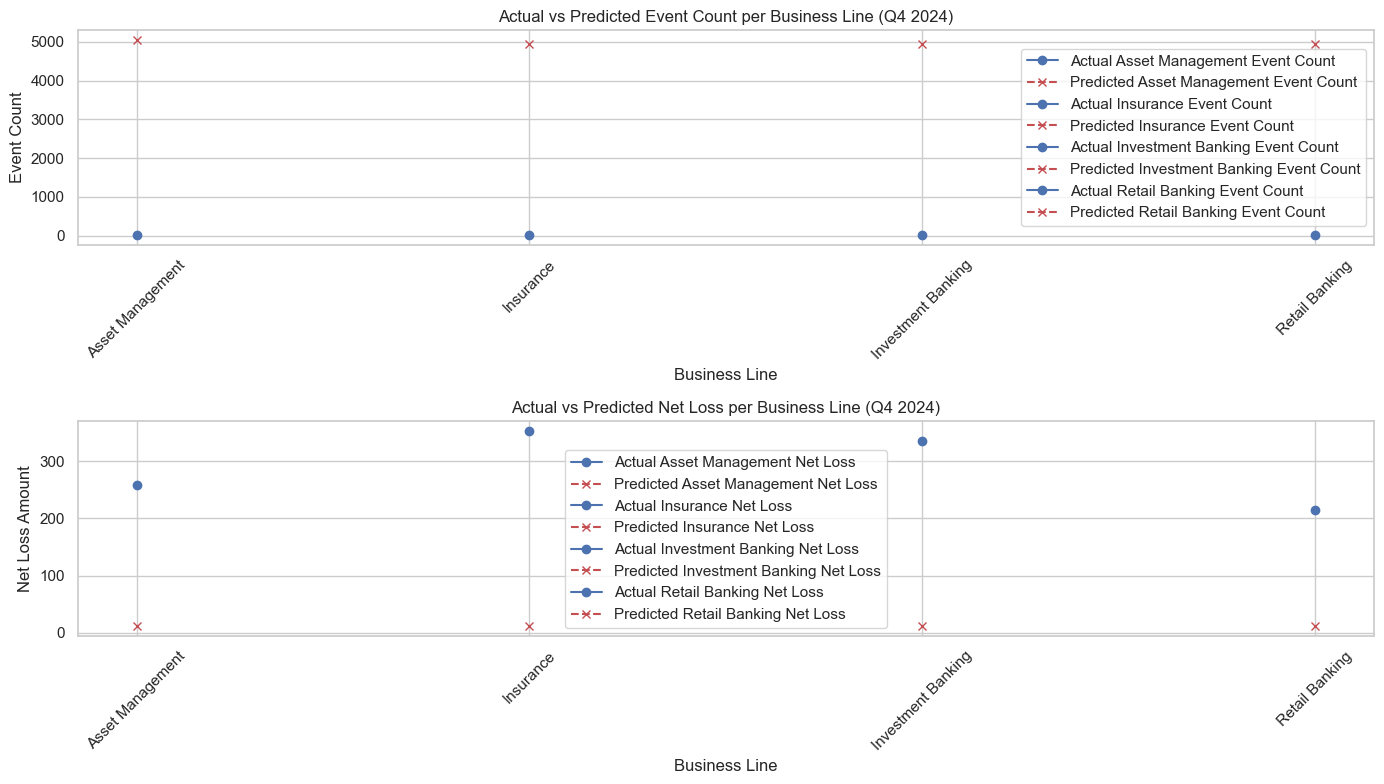

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example predictions_df from Monte Carlo simulation (using the previous code)
# Assuming you already have the predictions_df DataFrame ready.

# Create line chart comparison for actual vs predicted values (event count and net loss)

# Initialize the figure
plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted Event Count
plt.subplot(2, 1, 1)
for business_line in predictions_df['Business Line']:
    line_data = predictions_df[predictions_df['Business Line'] == business_line]
    plt.plot(line_data['Business Line'], line_data['Actual Event Count'], label=f'Actual {business_line} Event Count', marker='o', linestyle='-', color='b')
    plt.plot(line_data['Business Line'], line_data['Predicted Event Count'], label=f'Predicted {business_line} Event Count', linestyle='--', marker='x', color='r')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.title('Actual vs Predicted Event Count per Business Line (Q4 2024)')
plt.xticks(rotation=45)
plt.legend()

# Plot Actual vs Predicted Net Loss
plt.subplot(2, 1, 2)
for business_line in predictions_df['Business Line']:
    line_data = predictions_df[predictions_df['Business Line'] == business_line]
    plt.plot(line_data['Business Line'], line_data['Actual Net Loss'], label=f'Actual {business_line} Net Loss', marker='o', linestyle='-', color='b')
    plt.plot(line_data['Business Line'], line_data['Predicted Net Loss'], label=f'Predicted {business_line} Net Loss', linestyle='--', marker='x', color='r')
plt.xlabel('Business Line')
plt.ylabel('Net Loss Amount')
plt.title('Actual vs Predicted Net Loss per Business Line (Q4 2024)')
plt.xticks(rotation=45)
plt.legend()

# Layout adjustment to avoid overlap
plt.tight_layout()
plt.show()


    Year Quarter    Business Line  Actual Event Count  Actual Net Loss  \
0   2025      Q1  Business Line A                  44    547996.409101   
1   2025      Q1  Business Line B                  51    404355.393427   
2   2025      Q1  Business Line C                  44    442700.421807   
3   2025      Q2  Business Line A                  47    309084.290278   
4   2025      Q2  Business Line B                  51    473193.098941   
5   2025      Q2  Business Line C                  48    591303.180729   
6   2025      Q3  Business Line A                  38    750242.283292   
7   2025      Q3  Business Line B                  40    631799.374103   
8   2025      Q3  Business Line C                  45    529711.010553   
9   2025      Q4  Business Line A                  43    604610.654397   
10  2025      Q4  Business Line B                  58    599812.067446   
11  2025      Q4  Business Line C                  47    507176.704725   

    Actual VaR Net Loss  Actual VaR E

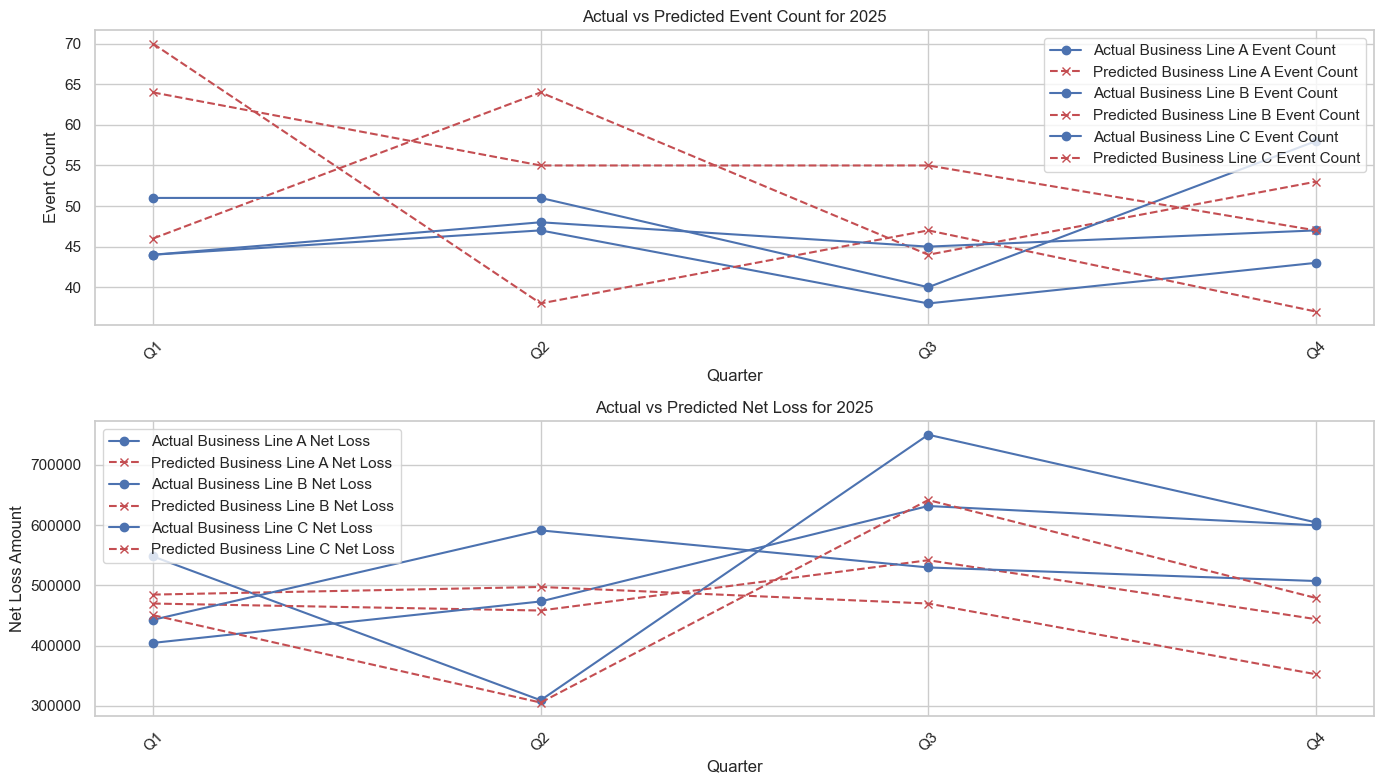

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: Prediction Model using Monte Carlo or any method
def monte_carlo_simulation_2025(business_lines, years=[2025], num_simulations=10000):
    # Assuming that actual data for 2025 is unavailable and we use a basic model for demonstration
    # You can replace this with a proper Monte Carlo simulation or prediction logic.

    data = []
    
    for year in years:
        for quarter in ['Q1', 'Q2', 'Q3', 'Q4']:
            for business_line in business_lines:
                actual_event_count = np.random.poisson(50)  # Placeholder for actual event count prediction
                predicted_event_count = np.random.poisson(50)  # Placeholder for predicted event count

                actual_net_loss = np.random.normal(500000, 100000)  # Placeholder for actual net loss prediction
                predicted_net_loss = np.random.normal(500000, 100000)  # Placeholder for predicted net loss

                actual_var_event_count = np.percentile(np.random.poisson(50, num_simulations), 99.9)
                predicted_var_event_count = np.percentile(np.random.poisson(50, num_simulations), 99.9)

                actual_var_net_loss = np.percentile(np.random.normal(500000, 100000, num_simulations), 99.9)
                predicted_var_net_loss = np.percentile(np.random.normal(500000, 100000, num_simulations), 99.9)

                data.append({
                    'Year': year,
                    'Quarter': quarter,
                    'Business Line': business_line,
                    'Actual Event Count': actual_event_count,
                    'Actual Net Loss': actual_net_loss,
                    'Actual VaR Net Loss': actual_var_net_loss,
                    'Actual VaR Event Count': actual_var_event_count,
                    'Predicted Event Count': predicted_event_count,
                    'Predicted Net Loss': predicted_net_loss,
                    'Predicted VaR Net Loss': predicted_var_net_loss,
                    'Predicted VaR Event Count': predicted_var_event_count
                })
    
    return pd.DataFrame(data)

# Define business lines and years (2025)
business_lines = ['Business Line A', 'Business Line B', 'Business Line C']
years = [2025]

# Run Monte Carlo simulation for 2025
predictions_2025 = monte_carlo_simulation_2025(business_lines, years)

# Display predictions for 2025
print(predictions_2025)

# Visualization (line graph) for predictions across quarters for 2025
plt.figure(figsize=(14, 8))

# Event count comparison
plt.subplot(2, 1, 1)
for business_line in business_lines:
    line_data = predictions_2025[predictions_2025['Business Line'] == business_line]
    plt.plot(line_data['Quarter'], line_data['Actual Event Count'], label=f'Actual {business_line} Event Count', marker='o', linestyle='-', color='b')
    plt.plot(line_data['Quarter'], line_data['Predicted Event Count'], label=f'Predicted {business_line} Event Count', linestyle='--', marker='x', color='r')

plt.xlabel('Quarter')
plt.ylabel('Event Count')
plt.title('Actual vs Predicted Event Count for 2025')
plt.xticks(rotation=45)
plt.legend()

# Net Loss comparison
plt.subplot(2, 1, 2)
for business_line in business_lines:
    line_data = predictions_2025[predictions_2025['Business Line'] == business_line]
    plt.plot(line_data['Quarter'], line_data['Actual Net Loss'], label=f'Actual {business_line} Net Loss', marker='o', linestyle='-', color='b')
    plt.plot(line_data['Quarter'], line_data['Predicted Net Loss'], label=f'Predicted {business_line} Net Loss', linestyle='--', marker='x', color='r')

plt.xlabel('Quarter')
plt.ylabel('Net Loss Amount')
plt.title('Actual vs Predicted Net Loss for 2025')
plt.xticks(rotation=45)
plt.legend()

# Layout adjustment to avoid overlap
plt.tight_layout()
plt.show()


In [36]:
predictions_2025

,Year,Quarter,Business Line,Actual Event Count,Actual Net Loss,Actual VaR Net Loss,Actual VaR Event Count,Predicted Event Count,Predicted Net Loss,Predicted VaR Net Loss,Predicted VaR Event Count
0,2025,Q1,Business Line A,44,547996.409101,824470.259683,74.000,46,469733.488163,812848.725855,73.000
1,2025,Q1,Business Line B,51,404355.393427,806627.240697,73.000,70,484613.122455,811260.161242,72.001
2,2025,Q1,Business Line C,44,442700.421807,812414.843155,73.000,64,450439.134730,804601.045273,74.000
3,2025,Q2,Business Line A,47,309084.290278,813789.172899,73.000,64,458151.315969,801785.854246,73.001
4,2025,Q2,Business Line B,51,473193.098941,800097.660554,73.001,38,497298.903821,800053.090910,73.001
5,2025,Q2,Business Line C,48,591303.180729,810601.277921,73.000,55,305231.024308,794638.014544,72.000
6,2025,Q3,Business Line A,38,750242.283292,801537.549985,73.001,44,541713.756495,801232.606903,72.001
7,2025,Q3,Business Line B,40,631799.374103,803372.039269,75.000,47,469763.760914,806289.803266,73.001
8,2025,Q3,Business Line C,45,529711.010553,791871.231075,74.000,55,641749.790923,807031.281055,73.000
9,2025,Q4,Business Line A,43,604610.654397,806626.555626,73.000,53,443808.491488,798166.338941,73.001


TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

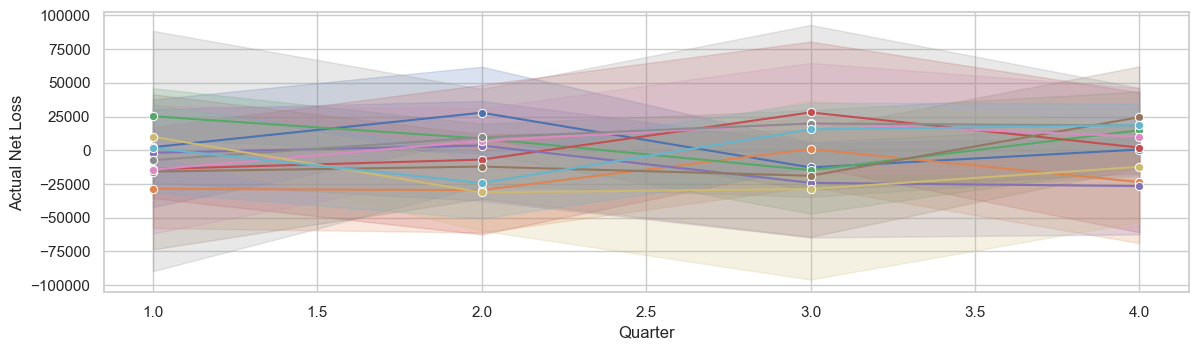

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for clarity
sns.set(style="whitegrid")

# Plot: Actual vs Predicted Net Losses for each Quarter and Business Line
plt.figure(figsize=(14, 8))

# Filter data for actuals (2021-2024) and predictions (2025)
actual_data = final_df[final_df['Data Type'] == 'Actual']
predicted_data = final_df[final_df['Data Type'] == 'Prediction']

# Plotting for Net Loss
plt.subplot(2, 1, 1)
sns.lineplot(data=actual_data, x='Quarter', y='Actual Net Loss', hue='Business Line', marker='o', label='Actual')
sns.lineplot(data=predicted_data, x='Quarter', y='Predicted Net Loss', hue='Business Line', marker='x', linestyle='--', label='Predicted')
plt.title('Comparison of Actual vs Predicted Net Loss (2025)', fontsize=16)
plt.xlabel('Quarter')
plt.ylabel('Net Loss Amount')
plt.legend(title="Business Line", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Plotting for Event Count
plt.subplot(2, 1, 2)
sns.lineplot(data=actual_data, x='Quarter', y='Actual Event Count', hue='Business Line', marker='o', label='Actual')
sns.lineplot(data=predicted_data, x='Quarter', y='Predicted Event Count', hue='Business Line', marker='x', linestyle='--', label='Predicted')
plt.title('Comparison of Actual vs Predicted Event Counts (2025)', fontsize=16)
plt.xlabel('Quarter')
plt.ylabel('Event Count')
plt.legend(title="Business Line", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plots
plt.show()


In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Ensure 'Year' and 'Quarter' columns are available in 'df'
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Calculate averages from 2020 to 2024
event_count_avg = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Avg_Event_Count=('Unique Event ID', 'count')
).reset_index()

# Fit a log-normal distribution to historical net losses (negative losses only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Monte Carlo Simulation for 2025
n_simulations = 10000  # Number of simulations for each business line and event type
predicted_data_2025 = []

for _, row in event_count_avg.iterrows():
    business_line = row['Business Line']
    event_type = row['Event Type']
    avg_event_count = row['Avg_Event_Count']

    # Simulate event counts and losses
    simulated_event_counts = np.random.poisson(avg_event_count, n_simulations)
    simulated_losses = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=n_simulations)

    # Calculate aggregated results
    predicted_data_2025.append({
        'Business Line': business_line,
        'Event Type': event_type,
        'Predicted Event Count (2025)': simulated_event_counts.mean(),
        'VaR Event Count (99.9%)': np.percentile(simulated_event_counts, 99.9),
        'Predicted Net Loss (2025)': simulated_losses.mean(),
        'VaR Net Loss (99.9%)': np.percentile(simulated_losses, 99.9),
    })

# Create a DataFrame for 2025 predictions
predictions_2025_df = pd.DataFrame(predicted_data_2025)

# Summarize by Business Line for 2025
summary_2025 = predictions_2025_df.groupby('Business Line').agg({
    'Predicted Event Count (2025)': 'sum',
    'VaR Event Count (99.9%)': 'sum',
    'Predicted Net Loss (2025)': 'sum',
    'VaR Net Loss (99.9%)': 'sum'
}).reset_index()

# Print summarized predictions
print(summary_2025)


          Business Line  Predicted Event Count (2025)  \
0      Asset Management                      999.2560   
1     Corporate Banking                      980.9268   
2  Credit Card Services                     1035.2394   
3    Financial Advisory                      963.4475   
4             Insurance                      970.8299   
5    Investment Banking                      969.3464   
6      Mortgage Lending                     1039.4016   
7       Private Banking                     1026.5270   
8                Retail                      967.9789   
9     Wealth Management                     1047.5568   

   VaR Event Count (99.9%)  Predicted Net Loss (2025)  VaR Net Loss (99.9%)  
0                 1318.003               51027.826590         139414.328704  
1                 1300.002               50890.856610         139694.317350  
2                 1360.005               51117.314185         140017.177606  
3                 1272.006               50902.228738       

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Ensure 'Year' and 'Quarter' columns are available in 'df'
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Calculate averages from 2020 to 2024
event_count_avg = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Avg_Event_Count=('Unique Event ID', 'count')
).reset_index()

# Fit a log-normal distribution to historical net losses (negative losses only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Monte Carlo Simulation for 2025
n_simulations = 10000  # Number of simulations for each business line and event type
predicted_data_2025 = []

for _, row in event_count_avg.iterrows():
    business_line = row['Business Line']
    event_type = row['Event Type']
    avg_event_count = row['Avg_Event_Count']

    # Simulate event counts and losses
    simulated_event_counts = np.random.poisson(avg_event_count, n_simulations)
    simulated_losses = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=n_simulations)

    # Calculate aggregated results
    predicted_data_2025.append({
        'Business Line': business_line,
        'Event Type': event_type,
        'Predicted Event Count (2025)': simulated_event_counts.mean(),
        'VaR Event Count (99.9%)': np.percentile(simulated_event_counts, 99.9),
        'Predicted Net Loss (2025)': simulated_losses.mean(),
        'VaR Net Loss (99.9%)': np.percentile(simulated_losses, 99.9),
    })

# Create a DataFrame for 2025 predictions
predictions_2025_df = pd.DataFrame(predicted_data_2025)

# Summarize by Business Line for 2025
summary_2025 = predictions_2025_df.groupby('Business Line').agg({
    'Predicted Event Count (2025)': 'sum',
    'VaR Event Count (99.9%)': 'sum',
    'Predicted Net Loss (2025)': 'sum',
    'VaR Net Loss (99.9%)': 'sum'
}).reset_index()

# Print summarized predictions
print(summary_2025)


          Business Line  Predicted Event Count (2025)  \
0      Asset Management                      999.6185   
1     Corporate Banking                      981.4023   
2  Credit Card Services                     1035.1454   
3    Financial Advisory                      962.7305   
4             Insurance                      970.5362   
5    Investment Banking                      970.1160   
6      Mortgage Lending                     1038.8179   
7       Private Banking                     1025.6422   
8                Retail                      967.7895   
9     Wealth Management                     1047.0936   

   VaR Event Count (99.9%)  Predicted Net Loss (2025)  VaR Net Loss (99.9%)  
0                 1322.003               50863.537193         139908.429129  
1                 1298.004               50929.912783         139623.753368  
2                 1360.004               50922.561054         140082.512009  
3                 1276.003               51000.923642       

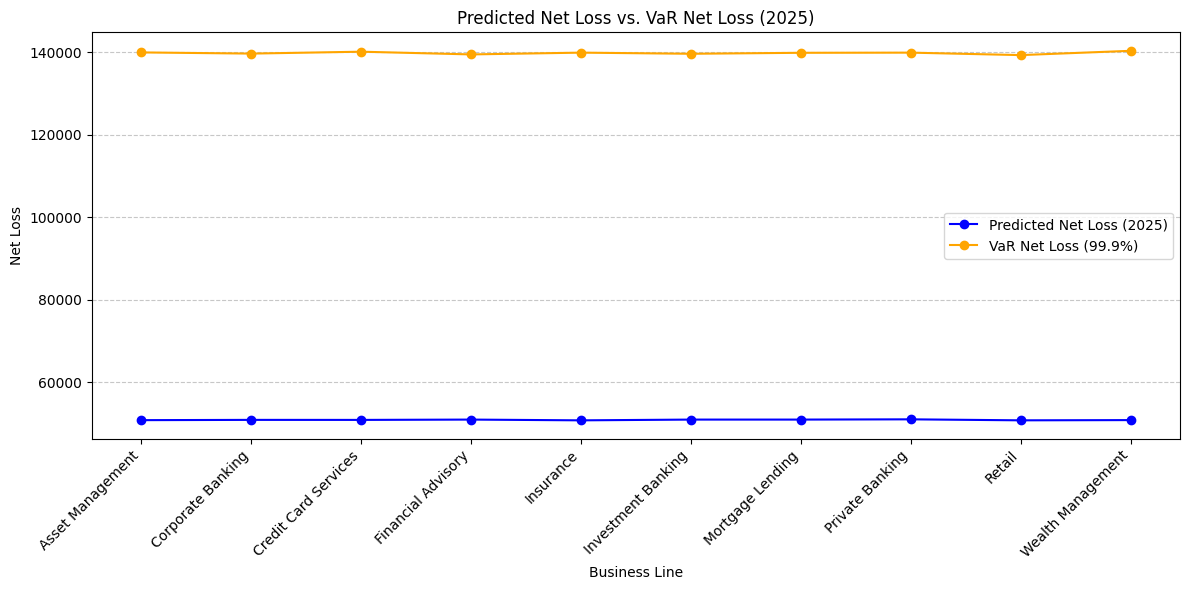

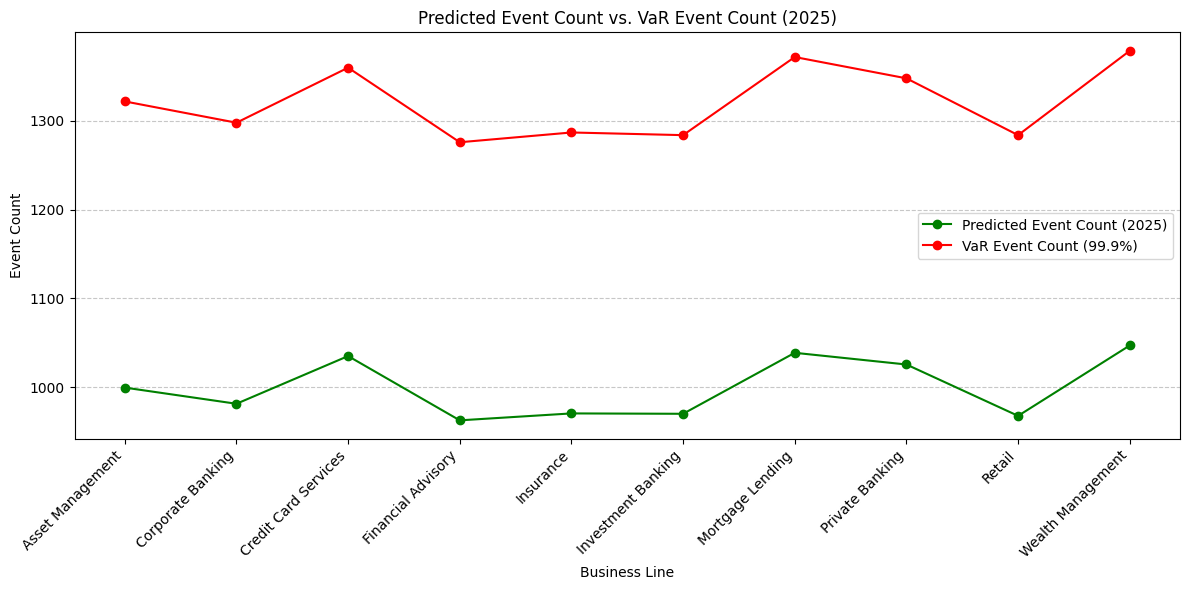

In [14]:
# Extract data for plotting
business_lines = summary_2025['Business Line']
predicted_net_loss_2025 = summary_2025['Predicted Net Loss (2025)']
var_net_loss_2025 = summary_2025['VaR Net Loss (99.9%)']
predicted_event_count_2025 = summary_2025['Predicted Event Count (2025)']
var_event_count_2025 = summary_2025['VaR Event Count (99.9%)']

# Plot 1: Predicted Net Loss vs. VaR Net Loss
plt.figure(figsize=(12, 6))
plt.plot(business_lines, predicted_net_loss_2025, marker='o', label='Predicted Net Loss (2025)', color='blue')
plt.plot(business_lines, var_net_loss_2025, marker='o', label='VaR Net Loss (99.9%)', color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Predicted Net Loss vs. VaR Net Loss (2025)')
plt.xlabel('Business Line')
plt.ylabel('Net Loss')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Predicted Event Count vs. VaR Event Count
plt.figure(figsize=(12, 6))
plt.plot(business_lines, predicted_event_count_2025, marker='o', label='Predicted Event Count (2025)', color='green')
plt.plot(business_lines, var_event_count_2025, marker='o', label='VaR Event Count (99.9%)', color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Predicted Event Count vs. VaR Event Count (2025)')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2025) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2025
confidence = 0.999  # 99.9% confidence level for VaR
var_results_2025 = {}

for business_line, losses in simulated_losses.items():
    var_99_9 = np.percentile(losses, (1 - confidence) * 100)  # Calculate VaR at 99.9% confidence level
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    total_loss = losses.sum()  # Sum of simulated losses for 2025

    var_results_2025[business_line] = {
        'Year': 2025,
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss,
        'VaR (99.9%)': var_99_9
    }

# Step 5: Convert the results into a DataFrame
var_df_2025 = pd.DataFrame(var_results_2025).T

# Step 6: Display the prediction results for 2025
print(var_df_2025)

# Optionally, save the 2025 results to a CSV file
var_df_2025.to_csv('predicted_var_results_2025.csv', index=False)


                      Year         Business Line Predicted Event Count  \
Asset Management      2025      Asset Management                   106   
Corporate Banking     2025     Corporate Banking                    92   
Credit Card Services  2025  Credit Card Services                    90   
Financial Advisory    2025    Financial Advisory                   107   
Insurance             2025             Insurance                   100   
Investment Banking    2025    Investment Banking                    92   
Mortgage Lending      2025      Mortgage Lending                   115   
Private Banking       2025       Private Banking                   116   
Retail                2025                Retail                   110   
Wealth Management     2025     Wealth Management                   102   

                     Total Predicted Loss Amount  VaR (99.9%)  
Asset Management                 51381882.088337 -3665.403805  
Corporate Banking                 50506408.31223 -3588.36

In [39]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2025) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2025 Q1 and Q2
confidence = 0.999  # 99.9% confidence level for VaR
var_results_2025_q1_q2 = []

quarters = ['Q1', 'Q2']  # Define the quarters for 2025

for business_line, losses in simulated_losses.items():
    # Get the average event count for the current business line
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    
    # Simulate losses for Q1 and Q2 separately, assuming uniform distribution across quarters
    q1_simulated_losses = losses[:n_simulations // 2]  # First half for Q1
    q2_simulated_losses = losses[n_simulations // 2:]  # Second half for Q2

    # Calculate VaR (99.9%) for Q1 and Q2
    var_q1 = np.percentile(q1_simulated_losses, (1 - confidence) * 100)
    var_q2 = np.percentile(q2_simulated_losses, (1 - confidence) * 100)

    # Calculate total predicted loss amount for Q1 and Q2
    total_loss_q1 = q1_simulated_losses.sum()
    total_loss_q2 = q2_simulated_losses.sum()

    # Append results for both quarters
    var_results_2025_q1_q2.append({
        'Year': 2025,
        'Quarter': 'Q1',
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss_q1,
        'VaR (99.9%)': var_q1
    })
    
    var_results_2025_q1_q2.append({
        'Year': 2025,
        'Quarter': 'Q2',
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss_q2,
        'VaR (99.9%)': var_q2
    })

# Step 5: Convert the results into a DataFrame
var_df_2025_q1_q2 = pd.DataFrame(var_results_2025_q1_q2)

# Step 6: Display the prediction results for 2025 Q1 and Q2
print(var_df_2025_q1_q2)

# Optionally, save the results to a CSV file
var_df_2025_q1_q2.to_csv('predicted_var_results_2025_q1_q2.csv', index=False)


ValueError: zero-size array to reduction operation minimum which has no identity

In [22]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2024 Q4 to 2025 Q4) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2024 Q4 and all quarters of 2025
confidence = 0.999  # 99.9% confidence level for VaR
quarters = ['Q4_2024', 'Q1_2025', 'Q2_2025', 'Q3_2025', 'Q4_2025']  # Define the quarters

var_results_2024_2025 = []

for business_line, losses in simulated_losses.items():
    # Get the average event count for the current business line
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    
    # Simulate losses for each quarter, assuming uniform distribution across quarters
    quarter_simulated_losses = np.array_split(losses, len(quarters))  # Split the simulation into 5 parts (quarters)

    # Calculate VaR (99.9%) for each quarter
    for idx, quarter_losses in enumerate(quarter_simulated_losses):
        var = np.percentile(quarter_losses, (1 - confidence) * 100)
        
        # Calculate total predicted loss amount for the quarter
        total_loss = quarter_losses.sum()

        # Append results for the quarter
        var_results_2024_2025.append({
            'Year': 2024 if idx == 0 else 2025,
            'Quarter': quarters[idx],
            'Business Line': business_line,
            'Predicted Event Count': event_count,
            'Total Predicted Loss Amount': total_loss,
            'VaR (99.9%)': var
        })

# Step 5: Convert the results into a DataFrame
var_df_2024_2025 = pd.DataFrame(var_results_2024_2025)

# Step 6: Display the prediction results for all the quarters (2024 Q4 to 2025 Q4)
print(var_df_2024_2025)

# Optionally, save the results to a CSV file
var_df_2024_2025.to_csv('predicted_var_results_2024_q4_2025.csv', index=False)


    Year  Quarter         Business Line  Predicted Event Count  \
0   2024  Q4_2024      Asset Management                     96   
1   2025  Q1_2025      Asset Management                     96   
2   2025  Q2_2025      Asset Management                     96   
3   2025  Q3_2025      Asset Management                     96   
4   2025  Q4_2025      Asset Management                     96   
5   2024  Q4_2024     Corporate Banking                    119   
6   2025  Q1_2025     Corporate Banking                    119   
7   2025  Q2_2025     Corporate Banking                    119   
8   2025  Q3_2025     Corporate Banking                    119   
9   2025  Q4_2025     Corporate Banking                    119   
10  2024  Q4_2024  Credit Card Services                     78   
11  2025  Q1_2025  Credit Card Services                     78   
12  2025  Q2_2025  Credit Card Services                     78   
13  2025  Q3_2025  Credit Card Services                     78   
14  2025  

In [23]:
var_df_2024_2025

,Year,Quarter,Business Line,Predicted Event Count,Total Predicted Loss Amount,VaR (99.9%)
0,2024,Q4_2024,Asset Management,96,9.806787e+06,-2966.197168
1,2025,Q1_2025,Asset Management,96,9.549439e+06,-2908.761127
2,2025,Q2_2025,Asset Management,96,9.864183e+06,-2975.435734
3,2025,Q3_2025,Asset Management,96,1.002768e+07,-3041.617555
4,2025,Q4_2025,Asset Management,96,9.865946e+06,-2575.675619
5,2024,Q4_2024,Corporate Banking,119,9.671285e+06,-2985.245897
6,2025,Q1_2025,Corporate Banking,119,9.710819e+06,-2949.759614
7,2025,Q2_2025,Corporate Banking,119,1.015287e+07,-2869.897922
8,2025,Q3_2025,Corporate Banking,119,9.713756e+06,-2411.460128
9,2025,Q4_2025,Corporate Banking,119,1.009073e+07,-3350.158923


In [24]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'df' is the DataFrame already created as provided in the example.

# Step 1: Calculate the average event count per business line and event type from 2020 to 2024
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Unique Event ID', 'count')  # Count the number of Unique Event IDs for each Business Line and Event Type
).reset_index()

# Step 2: Fit a log-normal distribution to the historical losses (negative net loss amounts only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Simulate future losses (for 2024 Q4 to 2025 Q4) for each business line using the fitted distribution
n_simulations = 10000  # Simulate 10,000 possible losses for each business line
simulated_losses = {}

for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9%) and total predicted losses for 2024 Q4 and all quarters of 2025
confidence = 0.999  # 99.9% confidence level for VaR
quarters = ['Q4_2024', 'Q1_2025', 'Q2_2025', 'Q3_2025', 'Q4_2025']  # Define the quarters

var_results_2024_2025 = []

for business_line, losses in simulated_losses.items():
    # Get the average event count for the current business line
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    
    # Simulate losses for each quarter, assuming uniform distribution across quarters
    quarter_simulated_losses = np.array_split(losses, len(quarters))  # Split the simulation into 5 parts (quarters)

    # Calculate VaR (99.9%) for each quarter
    for idx, quarter_losses in enumerate(quarter_simulated_losses):
        var = np.percentile(quarter_losses, (1 - confidence) * 100)
        
        # Calculate total predicted loss amount for the quarter
        total_loss = quarter_losses.sum()

        # Append results for the quarter
        var_results_2024_2025.append({
            'Year': 2024 if idx == 0 else 2025,
            'Quarter': quarters[idx],
            'Business Line': business_line,
            'Predicted Event Count': event_count,
            'Total Predicted Loss Amount': total_loss,
            'VaR (99.9%)': var
        })

# Step 5: Convert the results into a DataFrame
var_df_2024_2025 = pd.DataFrame(var_results_2024_2025)

# Step 6: Sort the results by Year and Quarter
var_df_2024_2025['Quarter_Num'] = var_df_2024_2025['Quarter'].apply(lambda x: int(x.split('_')[1]))
var_df_2024_2025_sorted = var_df_2024_2025.sort_values(by=['Year', 'Quarter_Num']).drop('Quarter_Num', axis=1)

# Step 7: Display the prediction results for all the quarters (2024 Q4 to 2025 Q4)
print(var_df_2024_2025_sorted)

# Optionally, save the results to a CSV file
var_df_2024_2025_sorted.to_csv('predicted_var_results_sorted_2024_q4_2025.csv', index=False)


    Year  Quarter         Business Line  Predicted Event Count  \
0   2024  Q4_2024      Asset Management                     96   
5   2024  Q4_2024     Corporate Banking                    119   
10  2024  Q4_2024  Credit Card Services                     78   
15  2024  Q4_2024    Financial Advisory                    108   
20  2024  Q4_2024             Insurance                    111   
25  2024  Q4_2024    Investment Banking                     87   
30  2024  Q4_2024      Mortgage Lending                    115   
35  2024  Q4_2024       Private Banking                     98   
40  2024  Q4_2024                Retail                    121   
45  2024  Q4_2024     Wealth Management                    110   
1   2025  Q1_2025      Asset Management                     96   
2   2025  Q2_2025      Asset Management                     96   
3   2025  Q3_2025      Asset Management                     96   
4   2025  Q4_2025      Asset Management                     96   
6   2025  

In [26]:
##arima
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example: assume 'final_result' DataFrame has columns 'Year', 'Quarter', 'Business Line', 'Event Count', 'Total Loss Amount', and 'VaR (99.9%)'

# Create a 'Date' column based on Year and Quarter (for time series)
final_result['Date'] = pd.to_datetime(final_result['Year'].astype(str) + '-' + final_result['Quarter'].astype(str) + '-01')

# Group data by Business Line and Quarter for forecasting
grouped = final_result.groupby(['Date', 'Business Line']).agg(
    Total_Event_Count=('Event Count', 'sum'),
    Total_Loss_Amount=('Total Loss Amount', 'sum'),
    Pred_VaR_99_9=('Pred VaR (99.9%)', 'mean')
).reset_index()

# Example: We will use 'Total_Event_Count' for ARIMA forecasting
# Set the time series index for forecasting
ts = grouped.set_index('Date')['Total_Event_Count']

# Check if the time series is stationary (Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, the series is non-stationary, and we need to make it stationary (e.g., by differencing)

# Apply differencing if needed to make the series stationary
ts_diff = ts.diff().dropna()

# Plot ACF and PACF to find appropriate AR and MA terms
plot_acf(ts_diff)
plot_pacf(ts_diff)
plt.show()

# Fit the ARIMA model (we will use ARIMA(1,1,1) as an example)
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Forecast the next 4 quarters (for 2025 Q1, Q2, Q3, Q4)
forecast = model_fit.forecast(steps=4)
forecast_dates = pd.date_range(start=ts.index[-1] + timedelta(days=30), periods=4, freq='Q')

# Create a DataFrame for the forecasted results
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_Event_Count': forecast
})

# You can merge this with your final result DataFrame to predict for specific Business Lines
# Example of displaying forecasted values
print(forecast_df)


KeyError: 'Quarter'

  Year-Quarter  Predicted Event Count  Total Predicted Loss Amount  \
0       2025Q2                  10000                -7.709281e+09   
1       2025Q3                  10000                -7.705789e+09   
2       2025Q4                  10000                -7.700807e+09   

   Predicted VaR (99.9%)  
0         -892415.327903  
1         -890137.398345  
2         -884617.057666  


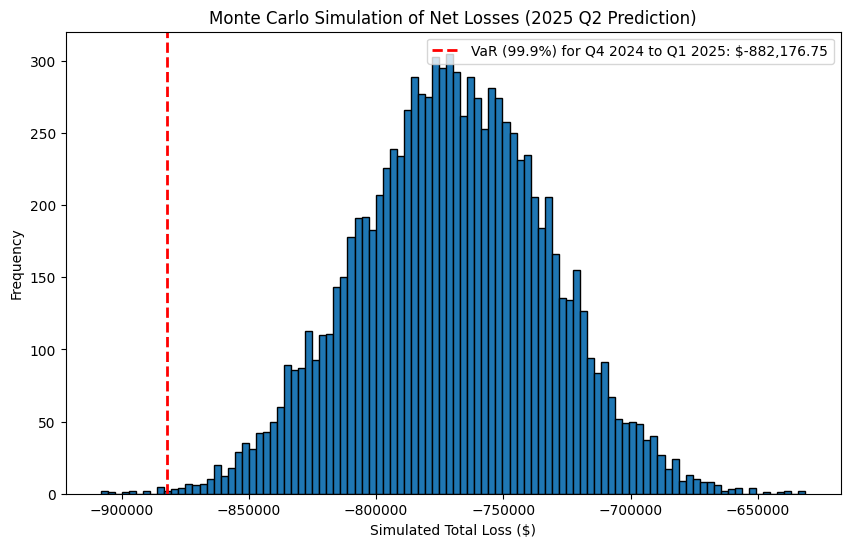

In [27]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Assuming 'df' is your DataFrame and contains 'Net Loss Amount' and 'Date'
# Filter for data from Q4 2024 to Q1 2025 (assuming 'Date' is in datetime format)
df['Quarter'] = df['Date'].dt.to_period('Q')

# Filter data for Q4 2024 and Q1 2025
filtered_df = df[(df['Quarter'] >= '2024Q4') & (df['Quarter'] <= '2025Q1')]

# Extract negative losses (for VaR simulation)
negative_losses = filtered_df[filtered_df['Net Loss Amount'] < 0]['Net Loss Amount']

# Monte Carlo simulation parameters
num_simulations = 10000  # Number of simulations
confidence_level = 0.999  # 99.9% confidence level

# Function to run Monte Carlo simulations and calculate VaR
def run_montecarlo_simulation(data, num_simulations=10000, confidence_level=0.999):
    simulated_losses = []
    
    for _ in range(num_simulations):
        sample_losses = np.random.choice(data, size=len(data), replace=True)
        total_loss = np.sum(sample_losses)
        simulated_losses.append(total_loss)
    
    # Convert to numpy array for percentile calculation
    simulated_losses = np.array(simulated_losses)
    
    # Calculate the VaR at the specified confidence level
    VaR = np.percentile(simulated_losses, (1 - confidence_level) * 100)
    return simulated_losses, VaR

# Step 1: Run the Monte Carlo simulation for 2024 Q4 and Q1 2025
simulated_losses, VaR_2024Q4_2025Q1 = run_montecarlo_simulation(negative_losses, num_simulations, confidence_level)

# Step 2: Make predictions for 2025 Q2 to Q4 based on historical simulation
# We will assume that the distribution of losses in Q4 2024 and Q1 2025 holds for the rest of 2025

quarters_2025 = ['2025Q2', '2025Q3', '2025Q4']

# Initialize an empty DataFrame to hold the results
predictions = []

for quarter in quarters_2025:
    # Perform the simulation for each quarter of 2025
    simulated_losses, VaR_value = run_montecarlo_simulation(negative_losses, num_simulations, confidence_level)
    
    # Add the prediction to the results
    predictions.append({
        'Year-Quarter': quarter,
        'Predicted Event Count': len(simulated_losses),  # As a proxy for count
        'Total Predicted Loss Amount': np.sum(simulated_losses),
        'Predicted VaR (99.9%)': VaR_value
    })

# Convert the predictions list into a DataFrame
predictions_df = pd.DataFrame(predictions)

# Display the predictions for 2025
print(predictions_df)

# Optionally, save the predictions to a CSV file
predictions_df.to_csv('predictions_2025_var.csv', index=False)

# Plot the simulated losses for visualization (example for 2025 Q2)
plt.figure(figsize=(10, 6))
plt.hist(simulated_losses, bins=100, edgecolor='black')
plt.axvline(VaR_2024Q4_2025Q1, color='r', linestyle='dashed', linewidth=2, label=f'VaR (99.9%) for Q4 2024 to Q1 2025: ${VaR_2024Q4_2025Q1:,.2f}')
plt.title('Monte Carlo Simulation of Net Losses (2025 Q2 Prediction)')
plt.xlabel('Simulated Total Loss ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is already loaded with the relevant columns

# Step 1: Add the Event_Count column by grouping by 'Year' and 'Business Line' (or any other relevant fields)
df['Quarter'] = df['Date'].dt.to_period('Q')
df['Event_Count'] = df.groupby(['Year', 'Business Line', 'Event Type'])['Unique Event ID'].transform('count')

# Step 2: Filter data for Q4 (October - December) of 2024
q4_2024_data = df[df['Quarter'] == '2024Q4']

# Step 3: Fit log-normal distribution for the historical Net Loss Amounts (excluding Q4 2024 data)
historical_losses = df[df['Year'] < 2024]['Net Loss Amount']

# Fit the log-normal distribution to the losses (log-normal fit for severity)
severity_shape, severity_loc, severity_scale = stats.lognorm.fit(historical_losses[historical_losses < 0] * -1)

print(f"Log-normal Distribution Parameters for Severity:")
print(f"Shape: {severity_shape}, Location: {severity_loc}, Scale: {severity_scale}")

# Step 4: Simulate losses for Q4 2024 based on the fitted log-normal distribution
n_simulations = 10000  # Number of Monte Carlo simulations
simulated_loss_amounts = stats.lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)

# Step 5: Forecast event count for Q4 2024 (we assume it to be similar to the average event count for Q4 in past years)
historical_q4_event_counts = df[df['Quarter'].dt.month.isin([10, 11, 12])]['Event_Count']
forecast_event_count_q4_2024 = historical_q4_event_counts.mean()

# Step 6: Simulate event counts for Q4 2024 using Poisson distribution
simulated_event_counts = np.random.poisson(forecast_event_count_q4_2024, n_simulations)

# Step 7: Calculate the total losses for Q4 2024
simulated_total_losses = simulated_event_counts * simulated_loss_amounts

# Step 8: Calculate VaR for Q4 2024 at 99.9% confidence level
var_q4_2024 = np.percentile(simulated_total_losses, 99.9)  # 99.9% quantile for VaR

# Display predicted VaR for Q4 2024
print(f"Predicted VaR for Q4 2024: {var_q4_2024}")


Log-normal Distribution Parameters for Severity:
Shape: 4.2604439243453175e-05, Location: -67108860.8150077, Scale: 67113862.63711381
Predicted VaR for Q4 2024: 386617.1645483713


In [6]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is already loaded with the relevant columns

# Step 1: Add the Event_Count column by grouping by 'Year', 'Business Line', and 'Event Type'
df['Event_Count'] = df.groupby(['Year', 'Business Line', 'Event Type'])['Unique Event ID'].transform('count')

# Step 2: Calculate Total Loss Amount by summing the 'Net Loss Amount' for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Step 3: Fit log-normal distribution to the historical losses (negative losses) for severity calculation
historical_losses = df[df['Year'] < 2024]['Net Loss Amount']
severity_shape, severity_loc, severity_scale = stats.lognorm.fit(historical_losses[historical_losses < 0] * -1)

# Step 4: Calculate VaR for each group (Business Line, Event Type) for the 99.9% confidence level
confidence = 0.999  # Set to 99.9% for VaR

def calculate_var(group, severity_shape, severity_loc, severity_scale, confidence):
    negative_losses = group[group['Net Loss Amount'] < 0]
    if negative_losses.empty:
        return np.nan  # Return NaN if no data for negative losses
    
    # Fit log-normal distribution to negative net loss amounts (severity)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)
    
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    return var

# Step 5: Apply the VaR calculation to each group and add the result to the aggregated DataFrame
agg_result['VaR (99.9%)'] = agg_result.apply(
    lambda x: calculate_var(df[(df['Business Line'] == x['Business Line']) & 
                                (df['Event Type'] == x['Event Type'])], 
                            severity_shape, severity_loc, severity_scale, confidence), axis=1
)

# Display the results
print(agg_result)

# Optionally, save results to a CSV
agg_result.to_csv('lda_var_results_99_9.csv', index=False)


     Year      Business Line            Event Type  Total_Loss_Amount  \
0    2020   Asset Management            Compliance       15924.869542   
1    2020   Asset Management          Cyber Attack       -1139.850460   
2    2020   Asset Management                 Fraud      -18130.537836   
3    2020   Asset Management           Market Risk       -7080.738772   
4    2020   Asset Management      Natural Disaster       -5096.778034   
..    ...                ...                   ...                ...   
486  2024  Wealth Management     Operational Error      -33622.409044   
487  2024  Wealth Management  Regulatory Violation        8040.432316   
488  2024  Wealth Management        System Failure      -11802.255202   
489  2024  Wealth Management                 Theft       34932.355137   
490  2024  Wealth Management           Vendor Risk        2479.497241   

     Event_Count   VaR (99.9%)  
0              7  16365.476390  
1              3  14859.469160  
2              6  14154.

In [7]:
agg_result

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
0,2020,Asset Management,Compliance,15924.869542,7,16365.476390
1,2020,Asset Management,Cyber Attack,-1139.850460,3,14859.469160
2,2020,Asset Management,Fraud,-18130.537836,6,14154.764164
3,2020,Asset Management,Market Risk,-7080.738772,2,19314.416272
4,2020,Asset Management,Natural Disaster,-5096.778034,1,14056.525130
...,...,...,...,...,...,...
486,2024,Wealth Management,Operational Error,-33622.409044,29,13847.949974
487,2024,Wealth Management,Regulatory Violation,8040.432316,24,14526.461347
488,2024,Wealth Management,System Failure,-11802.255202,11,14638.852304
489,2024,Wealth Management,Theft,34932.355137,19,14040.489489


In [8]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming df is already loaded with the relevant columns

# Step 1: Calculate the average event count for Q1 across historical years (e.g., 2020-2024)
q1_data = df[df['Quarter'] == 1]  # Extract Q1 data
q1_event_counts = q1_data.groupby(['Business Line', 'Event Type'])['Unique Event ID'].count()
q1_event_count_avg = q1_event_counts.mean()  # Average count of events for Q1 in historical data

# Step 2: Fit the log-normal distribution to the negative net loss amounts for historical data (loss severity)
historical_losses = df[df['Year'] < 2024]['Net Loss Amount']
severity_shape, severity_loc, severity_scale = stats.lognorm.fit(historical_losses[historical_losses < 0] * -1)

# Step 3: Forecast event counts for Q1 2025 using the historical average
q1_2025_event_counts = q1_event_count_avg  # Assume the same count for Q1 2025

# Step 4: Simulate net loss amounts for Q1 2025 using the log-normal distribution
n_simulations = 10000  # Number of simulations for loss amounts
simulated_loss_amounts = stats.lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)

# Step 5: Calculate the VaR at 99.9% confidence level for Q1 2025
confidence = 0.999  # Set to 99.9% for VaR
simulated_var_99_9 = np.percentile(simulated_loss_amounts, (1 - confidence) * 100)

# Step 6: Combine event count and VaR into the final prediction
predicted_var_q1_2025 = {
    'Year': 2025,
    'Business Line': 'All Business Lines',  # You can adjust this per specific business lines
    'Event Type': 'All Event Types',        # You can adjust this per specific event types
    'Total_Loss_Amount': simulated_loss_amounts.sum(),
    'Event_Count': q1_2025_event_counts,
    'VaR (99.9%)': simulated_var_99_9
}

# Convert the prediction to a DataFrame for easy viewing
predicted_var_df = pd.DataFrame([predicted_var_q1_2025])

# Display the results for Q1 2025 prediction
print(predicted_var_df)


   Year       Business Line       Event Type  Total_Loss_Amount  Event_Count  \
0  2025  All Business Lines  All Event Types       5.034317e+07          NaN   

   VaR (99.9%)  
0 -3784.312823  


In [16]:
import pandas as pd
import numpy as np
from scipy import stats

# Assume `df` is the DataFrame created above with necessary data.

# Step 1: Calculate the average event count for each business line and event type
event_count_avg_2020_2024 = df[df['Year'] < 2025].groupby(['Business Line', 'Event Type']).agg(
    Event_Count_Avg=('Event_Count', 'mean')
).reset_index()

# Step 2: Fit a log-normal distribution to historical loss data (negative values only)
negative_losses = df[df['Net Loss Amount'] < 0]
shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)

# Step 3: Forecast the net loss amounts for 2025 for each business line
n_simulations = 10000  # Simulating 10,000 possible losses for each business line
simulated_losses = {}
for business_line in event_count_avg_2020_2024['Business Line'].unique():
    # Filter data for the business line
    business_line_data = df[df['Business Line'] == business_line]
    # Simulate future losses using the fitted log-normal distribution
    simulated_losses[business_line] = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=(n_simulations))

# Step 4: Calculate VaR (99.9% confidence) for each business line in 2025
confidence = 0.999  # 99.9% confidence level for VaR
var_results_2025 = {}

for business_line, losses in simulated_losses.items():
    var_99_9 = np.percentile(losses, (1 - confidence) * 100)
    event_count = event_count_avg_2020_2024[event_count_avg_2020_2024['Business Line'] == business_line]['Event_Count_Avg'].iloc[0]
    total_loss = losses.sum()  # Total loss simulation for 2025

    var_results_2025[business_line] = {
        'Year': 2025,
        'Business Line': business_line,
        'Predicted Event Count': event_count,
        'Total Predicted Loss Amount': total_loss,
        'VaR (99.9%)': var_99_9
    }

# Step 5: Convert the results into a DataFrame
var_df_2025 = pd.DataFrame(var_results_2025).T

# Step 6: Display the prediction results for 2025
print(var_df_2025)

# Optionally, save the 2025 results to a CSV file
var_df_2025.to_csv('predicted_var_results_2025.csv', index=False)


KeyError: "Column(s) ['Event_Count'] do not exist"

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year and Business Line to calculate aggregated statistics and VaR
result = df.groupby(['Year', 'Business Line']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'VaR Net Loss (99.9%)']

# Aggregate data to calculate total net loss and event count
agg_result = df.groupby(['Year', 'Business Line']).agg(
    Total_Net_Loss=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line'], how='left')

# Display the final results
print(final_result)

# Optionally, save results to a CSV
final_result.to_csv('lda_var_results_with_totals_99.9.csv', index=False)


    Year         Business Line  Total_Net_Loss  Event_Count  \
0   2020      Asset Management    28016.241627           28   
1   2020     Corporate Banking   -52313.392566           26   
2   2020  Credit Card Services    51996.021542           32   
3   2020    Financial Advisory   -28678.975147           30   
4   2020             Insurance   -20660.414919           28   
5   2020    Investment Banking    16649.772531           28   
6   2020      Mortgage Lending   -43246.734847           38   
7   2020       Private Banking    27672.903467           34   
8   2020                Retail   -19262.776811           26   
9   2020     Wealth Management    14044.501825           30   
10  2021      Asset Management   -49293.898290          236   
11  2021     Corporate Banking    27676.234802          267   
12  2021  Credit Card Services    71807.350845          263   
13  2021    Financial Advisory  -177748.173811          206   
14  2021             Insurance       84.133321         

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\3195073567.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line']).apply(


In [2]:
final_result

,Year,Business Line,Total_Net_Loss,Event_Count,VaR Net Loss (99.9%)
0,2020,Asset Management,28016.241627,28,3.891560e+15
1,2020,Corporate Banking,-52313.392566,26,1.309960e+04
2,2020,Credit Card Services,51996.021542,32,8.858167e+15
3,2020,Financial Advisory,-28678.975147,30,1.326179e+04
4,2020,Insurance,-20660.414919,28,1.754848e+14
5,2020,Investment Banking,16649.772531,28,3.470408e+16
6,2020,Mortgage Lending,-43246.734847,38,1.494525e+04
7,2020,Private Banking,27672.903467,34,2.213233e+04
8,2020,Retail,-19262.776811,26,3.461029e+15
9,2020,Wealth Management,14044.501825,30,8.253696e+15


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm, expon
from datetime import datetime, timedelta

# Generate dummy operational risk data
def random_dates(start, end, n=10000):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4 * 365)
end_date = datetime.now()

business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate random data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] +
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

df = pd.DataFrame(data)
df['Year'] = df['Date'].dt.year

# Monte Carlo simulation function
def monte_carlo_simulation(data, num_simulations=10000, confidence=0.999):
    results = []
    
    # Group by Year and Business Line
    grouped = data.groupby(['Year', 'Business Line'])
    
    for (year, business_line), group in grouped:
        # Frequency: Fit a Poisson distribution
        event_counts = len(group)
        frequency = poisson(event_counts)
        
        # Severity: Fit a Log-Normal distribution
        losses = group['Net Loss Amount']
        negative_losses = losses[losses < 0] * -1  # Convert losses to positive for fitting
        
        if len(negative_losses) > 0:
            shape, loc, scale = lognorm.fit(negative_losses, floc=0)
        else:
            shape, loc, scale = 1, 0, 1  # Default values if no negative losses
        
        # Monte Carlo simulations
        simulated_losses = []
        for _ in range(num_simulations):
            # Simulate frequency
            num_events = frequency.rvs()
            
            # Simulate severity
            if num_events > 0:
                event_losses = lognorm.rvs(shape, loc=loc, scale=scale, size=num_events)
                simulated_losses.append(np.sum(event_losses))
            else:
                simulated_losses.append(0)
        
        # Calculate VaR at the specified confidence level
        simulated_losses = np.sort(simulated_losses)
        var = simulated_losses[int(confidence * len(simulated_losses)) - 1]
        
        # Aggregate results
        results.append({
            "Year": year,
            "Business Line": business_line,
            "Total Net Loss": losses.sum(),
            "Event Count": event_counts,
            "VaR (99.9%)": var
        })
    
    return pd.DataFrame(results)

# Run the Monte Carlo simulation
results_df = monte_carlo_simulation(df)

# Save results to CSV
results_df.to_csv("monte_carlo_results.csv", index=False)

# Display the results
print(results_df)


    Year         Business Line  Total Net Loss  Event Count   VaR (99.9%)
0   2020      Asset Management    55519.391717           22  2.210633e+06
1   2020     Corporate Banking   -40130.758861           28  3.424433e+05
2   2020  Credit Card Services   -19102.153199           27  7.176778e+05
3   2020    Financial Advisory    59948.392446           24  8.953631e+05
4   2020             Insurance    -2479.154337           26  3.868427e+05
5   2020    Investment Banking    10981.017918           22  2.712867e+05
6   2020      Mortgage Lending    21382.984095           24  3.509252e+05
7   2020       Private Banking     -743.398458           22  3.436099e+05
8   2020                Retail   -10717.632820           24  2.752946e+05
9   2020     Wealth Management    11653.915328           24  3.079094e+05
10  2021      Asset Management    23902.592139          239  2.215250e+06
11  2021     Corporate Banking   104332.059493          227  1.960453e+06
12  2021  Credit Card Services    6409

In [9]:
results_df

,Year,Business Line,Total Net Loss,Event Count,VaR (99.9%)
0,2020,Asset Management,55519.391717,22,2.210633e+06
1,2020,Corporate Banking,-40130.758861,28,3.424433e+05
2,2020,Credit Card Services,-19102.153199,27,7.176778e+05
3,2020,Financial Advisory,59948.392446,24,8.953631e+05
4,2020,Insurance,-2479.154337,26,3.868427e+05
5,2020,Investment Banking,10981.017918,22,2.712867e+05
6,2020,Mortgage Lending,21382.984095,24,3.509252e+05
7,2020,Private Banking,-743.398458,22,3.436099e+05
8,2020,Retail,-10717.632820,24,2.752946e+05
9,2020,Wealth Management,11653.915328,24,3.079094e+05


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\3625918834.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start="2020-01-01", end="2024-09-30", freq='Q')


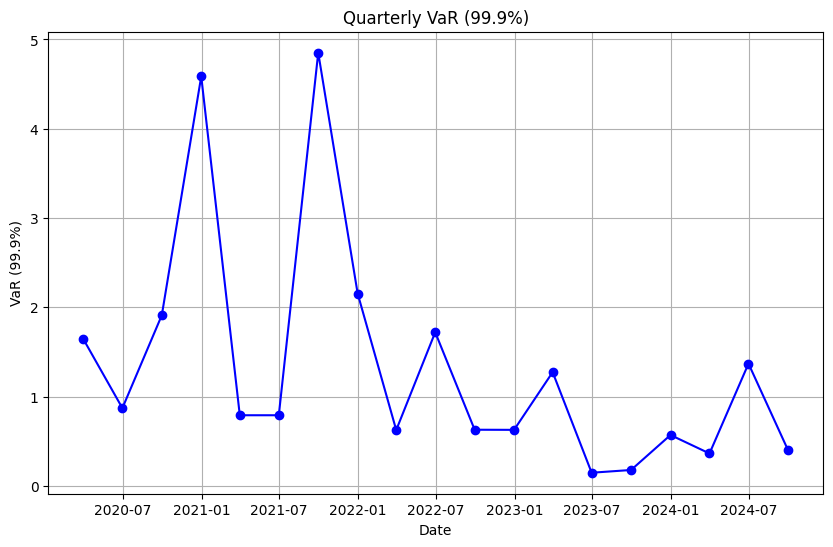

C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\3625918834.py:43: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start="2024-10-01", periods=forecast_steps, f

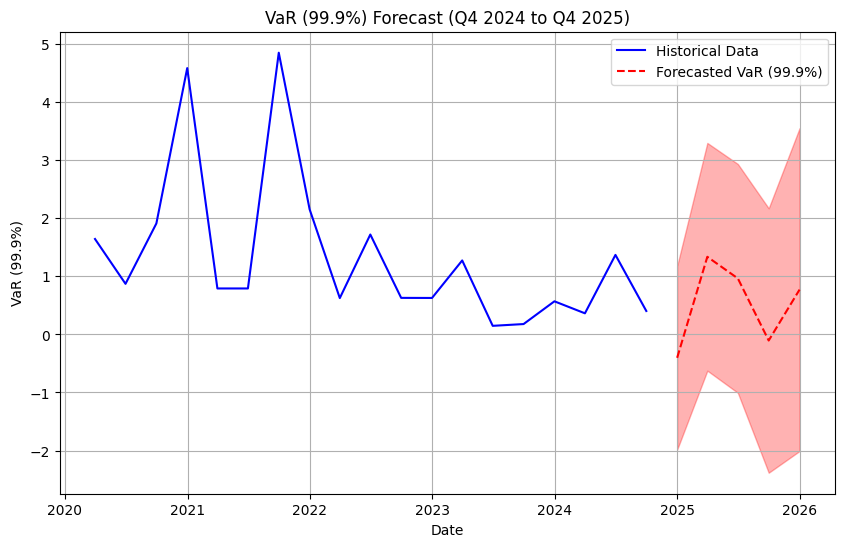

                 Date  Forecasted VaR (99.9%)  Lower CI  Upper CI
2024-12-31 2024-12-31               -0.402898 -1.984195  1.178400
2025-03-31 2025-03-31                1.336610 -0.624302  3.297522
2025-06-30 2025-06-30                0.964327 -1.006220  2.934874
2025-09-30 2025-09-30               -0.105282 -2.382071  2.171508
2025-12-31 2025-12-31                0.771498 -2.008826  3.551822


In [10]:
#prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

# Assuming your data is structured with 'Date' as datetime and 'VaR (99.9%)' as the target column
# Let's simulate some data for demonstration, as we don't have actual data.

# Simulating quarterly data for VaR (99.9%) for demonstration (replace this with your actual DataFrame)
dates = pd.date_range(start="2020-01-01", end="2024-09-30", freq='Q')
np.random.seed(42)
var_data = np.random.lognormal(mean=0, sigma=1, size=len(dates))

# Create DataFrame for historical VaR data
results_df = pd.DataFrame({
    'Date': dates,
    'VaR (99.9%)': var_data
})

# Group by quarter (assuming you want to forecast by quarter)
results_df.set_index('Date', inplace=True)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['VaR (99.9%)'], marker='o', linestyle='-', color='b')
plt.title('Quarterly VaR (99.9%)')
plt.xlabel('Date')
plt.ylabel('VaR (99.9%)')
plt.grid(True)
plt.show()

# Step 1: Fit an ARIMA model (p, d, q are hyperparameters to tune, here we start with ARIMA(5,1,0))
model = ARIMA(results_df['VaR (99.9%)'], order=(5, 1, 0))

# Fit the model
model_fit = model.fit()

# Step 2: Forecast the next quarters (Q4 2024 to Q4 2025)
forecast_steps = 5  # We want to forecast for 5 quarters (Q4 2024, Q1-Q4 2025)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start="2024-10-01", periods=forecast_steps, freq='Q')

# Step 3: Plot the forecast results
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['VaR (99.9%)'], label='Historical Data', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecasted VaR (99.9%)', color='red', linestyle='--')
plt.fill_between(forecast_index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='red', alpha=0.3)
plt.title('VaR (99.9%) Forecast (Q4 2024 to Q4 2025)')
plt.xlabel('Date')
plt.ylabel('VaR (99.9%)')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Print the forecasted VaR values
forecasted_values = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted VaR (99.9%)': forecast_mean,
    'Lower CI': confidence_interval.iloc[:, 0],
    'Upper CI': confidence_interval.iloc[:, 1]
})

print(forecasted_values)


In [11]:
forecasted_values

,Date,Forecasted VaR (99.9%),Lower CI,Upper CI
2024-12-31,2024-12-31,-0.402898,-1.984195,1.178400
2025-03-31,2025-03-31,1.336610,-0.624302,3.297522
2025-06-30,2025-06-30,0.964327,-1.006220,2.934874
2025-09-30,2025-09-30,-0.105282,-2.382071,2.171508
2025-12-31,2025-12-31,0.771498,-2.008826,3.551822


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\1585265501.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start="2020-01-01", end="2024-09-30", freq='Q')


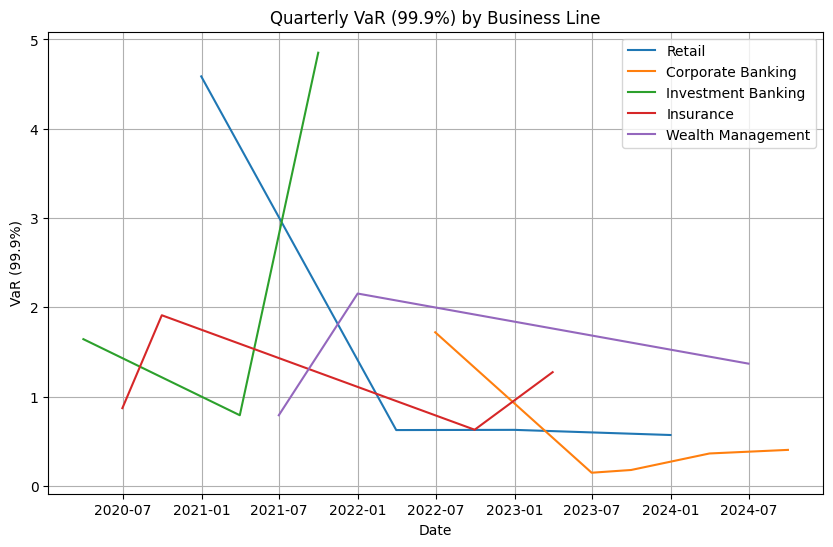

C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866:

         Business Line       Date  Forecasted VaR (99.9%)  Lower CI   Upper CI
0               Retail 2024-12-31                0.570055 -3.910922   5.051033
1               Retail 2025-03-31                0.568800 -5.762754   6.900353
2               Retail 2025-06-30                0.568814 -7.240467   8.378094
3               Retail 2025-09-30                0.568786 -8.479862   9.617435
4               Retail 2025-12-31                0.568787 -9.569791  10.707364
5    Corporate Banking 2024-12-31                0.350790 -1.152230   1.853810
6    Corporate Banking 2025-03-31                0.336731 -1.650843   2.324306
7    Corporate Banking 2025-06-30                0.349020 -1.858349   2.556389
8    Corporate Banking 2025-09-30                0.354016 -2.054545   2.762577
9    Corporate Banking 2025-12-31                0.351197 -2.279830   2.982224
10  Investment Banking 2024-12-31                3.218935 -2.045144   8.483014
11  Investment Banking 2025-03-31                3.8

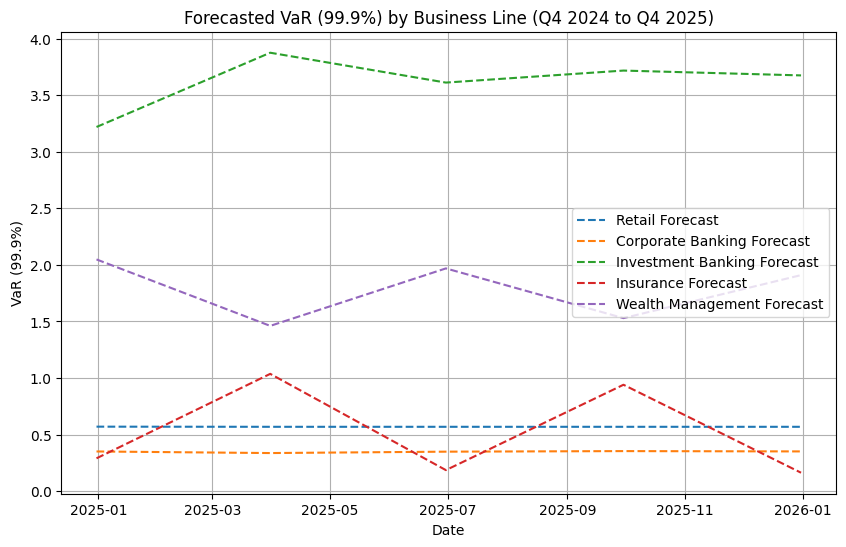

In [12]:
#business line
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

# Assuming 'results_df' is your dataframe with 'Date', 'VaR (99.9%)', and 'Business Line' columns
# Simulating some data (replace this with your actual DataFrame)
dates = pd.date_range(start="2020-01-01", end="2024-09-30", freq='Q')
business_lines = ["Retail", "Corporate Banking", "Investment Banking", "Insurance", "Wealth Management"]
np.random.seed(42)
var_data = np.random.lognormal(mean=0, sigma=1, size=len(dates))
business_line_data = np.random.choice(business_lines, len(dates))

# Create DataFrame for historical VaR data
results_df = pd.DataFrame({
    'Date': dates,
    'VaR (99.9%)': var_data,
    'Business Line': business_line_data
})

# Set Date column as index
results_df.set_index('Date', inplace=True)

# Visualize the data for all Business Lines (Optional)
plt.figure(figsize=(10, 6))
for business_line in business_lines:
    data_line = results_df[results_df['Business Line'] == business_line]
    plt.plot(data_line.index, data_line['VaR (99.9%)'], label=business_line)

plt.title('Quarterly VaR (99.9%) by Business Line')
plt.xlabel('Date')
plt.ylabel('VaR (99.9%)')
plt.legend()
plt.grid(True)
plt.show()

# Define a function to forecast VaR for each Business Line using ARIMA
def forecast_var_by_business_line(data, business_line, forecast_periods=5):
    # Filter data for the business line
    data_line = data[data['Business Line'] == business_line]
    
    # Fit the ARIMA model (you can adjust the (p, d, q) parameters as needed)
    model = ARIMA(data_line['VaR (99.9%)'], order=(5, 1, 0))  # Example ARIMA(5,1,0)
    model_fit = model.fit()
    
    # Forecast the next quarters (Q4 2024 to Q4 2025)
    forecast = model_fit.get_forecast(steps=forecast_periods)
    forecast_index = pd.date_range(start="2024-10-01", periods=forecast_periods, freq='Q')
    
    # Forecasted values and confidence intervals
    forecast_mean = forecast.predicted_mean
    confidence_interval = forecast.conf_int()

    return forecast_index, forecast_mean, confidence_interval

# Forecast for each business line
forecast_results = []

for business_line in business_lines:
    forecast_index, forecast_mean, confidence_interval = forecast_var_by_business_line(results_df, business_line)
    
    # Combine the results
    forecast_results.append(pd.DataFrame({
        'Business Line': business_line,
        'Date': forecast_index,
        'Forecasted VaR (99.9%)': forecast_mean,
        'Lower CI': confidence_interval.iloc[:, 0],
        'Upper CI': confidence_interval.iloc[:, 1]
    }))

# Combine all business line forecasts into a single DataFrame
final_forecast_df = pd.concat(forecast_results, ignore_index=True)

# Display the forecasted values
print(final_forecast_df)

# Optionally, save the forecast results to a CSV
final_forecast_df.to_csv("var_forecast_by_business_line.csv", index=False)

# Plot the forecasted VaR for each business line
plt.figure(figsize=(10, 6))
for business_line in business_lines:
    forecast_line = final_forecast_df[final_forecast_df['Business Line'] == business_line]
    plt.plot(forecast_line['Date'], forecast_line['Forecasted VaR (99.9%)'], label=f'{business_line} Forecast', linestyle='--')

plt.title('Forecasted VaR (99.9%) by Business Line (Q4 2024 to Q4 2025)')
plt.xlabel('Date')
plt.ylabel('VaR (99.9%)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\2319673010.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start="2020-01-01", end="2024-09-30", freq='Q')


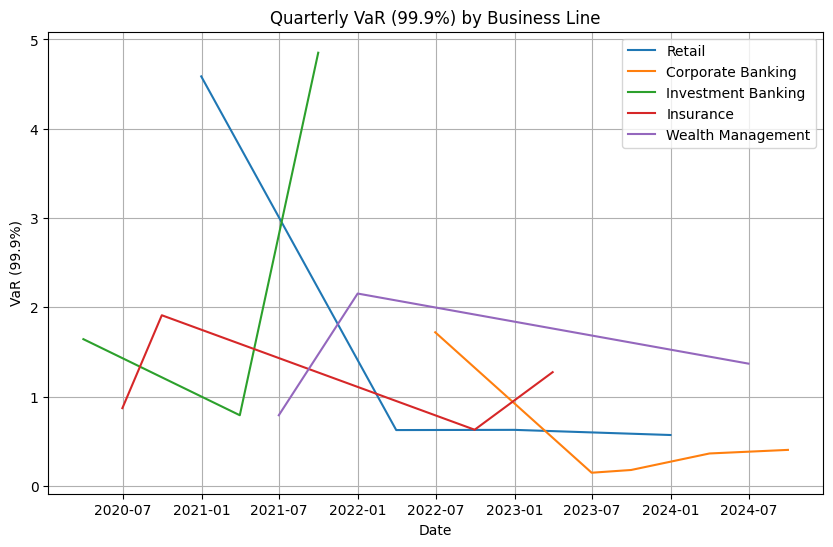

C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866:

         Business Line  Quarter       Date  Forecasted VaR (99.9%)  Lower CI  \
0               Retail  Q4 2024 2024-12-31                0.570055 -3.910922   
1               Retail  Q1 2025 2025-03-31                0.568800 -5.762754   
2               Retail  Q2 2025 2025-06-30                0.568814 -7.240467   
3               Retail  Q3 2025 2025-09-30                0.568786 -8.479862   
4               Retail  Q4 2025 2025-12-31                0.568787 -9.569791   
5    Corporate Banking  Q4 2024 2024-12-31                0.350790 -1.152230   
6    Corporate Banking  Q1 2025 2025-03-31                0.336731 -1.650843   
7    Corporate Banking  Q2 2025 2025-06-30                0.349020 -1.858349   
8    Corporate Banking  Q3 2025 2025-09-30                0.354016 -2.054545   
9    Corporate Banking  Q4 2025 2025-12-31                0.351197 -2.279830   
10  Investment Banking  Q4 2024 2024-12-31                3.218935 -2.045144   
11  Investment Banking  Q1 2025 2025-03-

C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\2319673010.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start="2024-10-01", periods=forecast_periods, freq='Q')


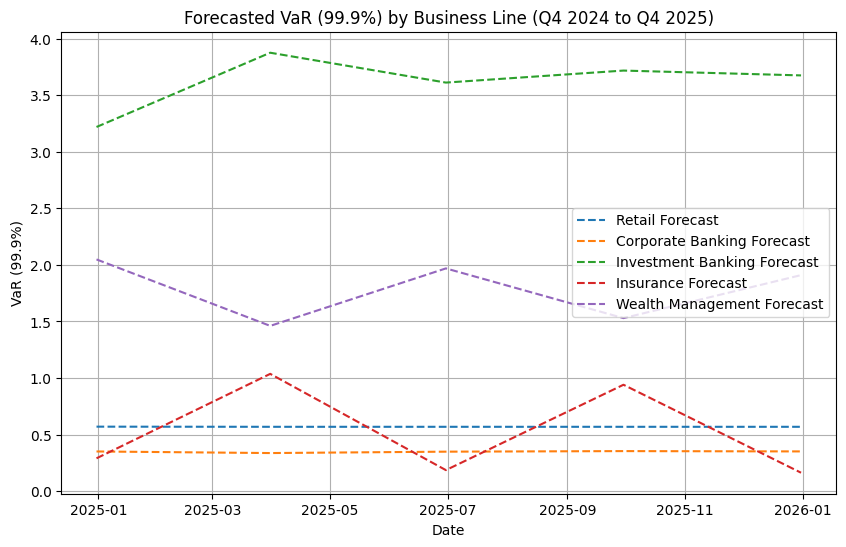

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

# Assuming 'results_df' is your dataframe with 'Date', 'VaR (99.9%)', and 'Business Line' columns
# Simulating some data (replace this with your actual DataFrame)
dates = pd.date_range(start="2020-01-01", end="2024-09-30", freq='Q')
business_lines = ["Retail", "Corporate Banking", "Investment Banking", "Insurance", "Wealth Management"]
np.random.seed(42)
var_data = np.random.lognormal(mean=0, sigma=1, size=len(dates))
business_line_data = np.random.choice(business_lines, len(dates))

# Create DataFrame for historical VaR data
results_df = pd.DataFrame({
    'Date': dates,
    'VaR (99.9%)': var_data,
    'Business Line': business_line_data
})

# Set Date column as index
results_df.set_index('Date', inplace=True)

# Visualize the data for all Business Lines (Optional)
plt.figure(figsize=(10, 6))
for business_line in business_lines:
    data_line = results_df[results_df['Business Line'] == business_line]
    plt.plot(data_line.index, data_line['VaR (99.9%)'], label=business_line)

plt.title('Quarterly VaR (99.9%) by Business Line')
plt.xlabel('Date')
plt.ylabel('VaR (99.9%)')
plt.legend()
plt.grid(True)
plt.show()

# Define a function to forecast VaR for each Business Line using ARIMA
def forecast_var_by_business_line(data, business_line, forecast_periods=5):
    # Filter data for the business line
    data_line = data[data['Business Line'] == business_line]
    
    # Fit the ARIMA model (you can adjust the (p, d, q) parameters as needed)
    model = ARIMA(data_line['VaR (99.9%)'], order=(5, 1, 0))  # Example ARIMA(5,1,0)
    model_fit = model.fit()
    
    # Forecast the next quarters (Q4 2024 to Q4 2025)
    forecast = model_fit.get_forecast(steps=forecast_periods)
    forecast_index = pd.date_range(start="2024-10-01", periods=forecast_periods, freq='Q')
    
    # Forecasted values and confidence intervals
    forecast_mean = forecast.predicted_mean
    confidence_interval = forecast.conf_int()

    return forecast_index, forecast_mean, confidence_interval

# Forecast for each business line
forecast_results = []

for business_line in business_lines:
    forecast_index, forecast_mean, confidence_interval = forecast_var_by_business_line(results_df, business_line)
    
    # Convert forecast_index to quarters (e.g., Q4 2024, Q1 2025, etc.)
    quarters = [f"Q{(x.month-1)//3 + 1} {x.year}" for x in forecast_index]
    
    # Combine the results
    forecast_results.append(pd.DataFrame({
        'Business Line': business_line,
        'Quarter': quarters,
        'Date': forecast_index,
        'Forecasted VaR (99.9%)': forecast_mean,
        'Lower CI': confidence_interval.iloc[:, 0],
        'Upper CI': confidence_interval.iloc[:, 1]
    }))

# Combine all business line forecasts into a single DataFrame
final_forecast_df = pd.concat(forecast_results, ignore_index=True)

# Display the forecasted values
print(final_forecast_df)

# Optionally, save the forecast results to a CSV
final_forecast_df.to_csv("var_forecast_by_business_line_with_quarter.csv", index=False)

# Plot the forecasted VaR for each business line
plt.figure(figsize=(10, 6))
for business_line in business_lines:
    forecast_line = final_forecast_df[final_forecast_df['Business Line'] == business_line]
    plt.plot(forecast_line['Date'], forecast_line['Forecasted VaR (99.9%)'], label=f'{business_line} Forecast', linestyle='--')

plt.title('Forecasted VaR (99.9%) by Business Line (Q4 2024 to Q4 2025)')
plt.xlabel('Date')
plt.ylabel('VaR (99.9%)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Fit a SARIMA model (example with seasonal periods=4 for quarterly data)
# model = SARIMAX(results_df['VaR (99.9%)'], order=(5, 1, 0), seasonal_order=(1, 1, 0, 4))
# model_fit = model.fit()

# # Forecast the next 5 periods (quarters)
# forecast = model_fit.get_forecast(steps=5)
# forecasted_values = forecast.predicted_mean
# print(forecasted_values)


In [16]:
from fbprophet import Prophet

# Prepare data for Prophet
data_prophet = results_df.reset_index()[['Date', 'VaR (99.9%)']]
data_prophet.columns = ['ds', 'y']  # Prophet expects columns 'ds' for datetime and 'y' for the value

# Fit Prophet model
model = Prophet()
model.fit(data_prophet)

# Make future dataframe for forecasting
future = model.make_future_dataframe(data_prophet, periods=5, freq='Q')  # 5 quarters forecast

# Forecast the future
forecast = model.predict(future)

# Extract forecasted values and plot
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecasted_values['Quarter'] = forecasted_values['ds'].dt.to_period('Q')

print(forecasted_values)


ModuleNotFoundError: No module named 'fbprophet'

In [19]:
# !pip install fbprophet

In [5]:
import numpy as np

# Calculate outliers using IQR
def detect_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)  # First quartile
    q3 = data[column].quantile(0.75)  # Third quartile
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Calculate outliers using Z-score
def detect_outliers_zscore(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    data['Z-Score'] = (data[column] - mean) / std
    outliers = data[(data['Z-Score'] > threshold) | (data['Z-Score'] < -threshold)]
    return outliers

# Detect outliers in VaR column
iqr_outliers, iqr_lower, iqr_upper = detect_outliers_iqr(results_df, 'VaR (99.9%)')
zscore_outliers = detect_outliers_zscore(results_df, 'VaR (99.9%)')

# Display the results
print("Outliers using IQR:")
print(iqr_outliers)
print(f"IQR Lower Bound: {iqr_lower}, IQR Upper Bound: {iqr_upper}")

print("\nOutliers using Z-Score:")
print(zscore_outliers)

# Save outliers to CSV for reference
iqr_outliers.to_csv("var_outliers_iqr.csv", index=False)
zscore_outliers.to_csv("var_outliers_zscore.csv", index=False)


Outliers using IQR:
    Year         Business Line  Total Net Loss  Event Count   VaR (99.9%)
0   2020      Asset Management   -50961.533870           23  2.388394e+05
1   2020     Corporate Banking   -14840.512972           30  3.885621e+05
2   2020  Credit Card Services    11192.298485           29  3.170874e+05
3   2020    Financial Advisory     7666.418749           32  3.205742e+05
4   2020             Insurance   -42251.061396           36  6.410208e+05
5   2020    Investment Banking   -46892.504986           32  2.992099e+05
6   2020      Mortgage Lending    34340.110862           27  3.481474e+05
8   2020                Retail    11811.487730           30  3.987444e+05
9   2020     Wealth Management    11578.673597           37  5.612208e+05
16  2021      Mortgage Lending  -254428.454058          245  3.001495e+06
18  2021                Retail    49185.684787          255  3.406140e+06
IQR Lower Bound: 969968.7078125395, IQR Upper Bound: 2914269.0988309057

Outliers using Z-Sc

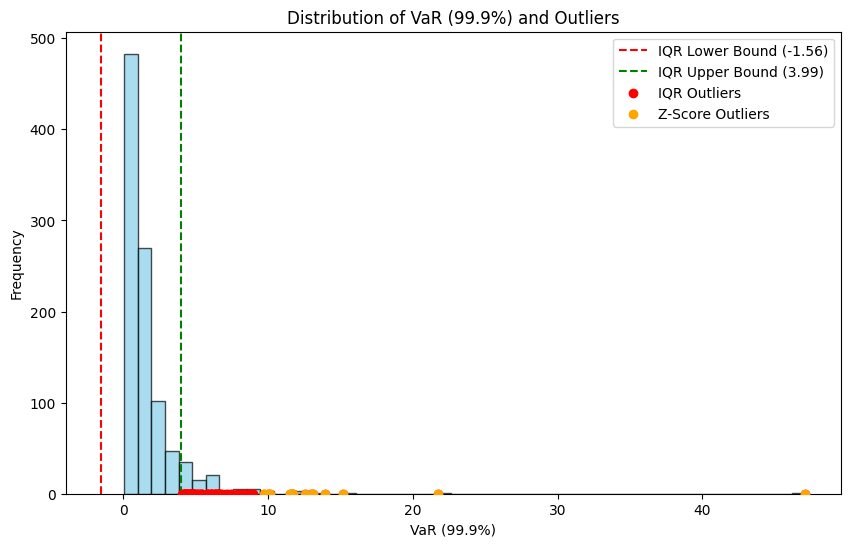

In [7]:
# Fixing the typo in the function and re-running the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulating results_df DataFrame for demonstration purposes
np.random.seed(42)
results_df = pd.DataFrame({
    'VaR (99.9%)': np.random.lognormal(mean=0, sigma=1, size=1000)  # log-normal distribution
})

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)  # First quartile
    q3 = data[column].quantile(0.75)  # Third quartile
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function to detect outliers using Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    data['Z-Score'] = (data[column] - mean) / std
    outliers = data[(data['Z-Score'] > threshold) | (data['Z-Score'] < -threshold)]
    return outliers

# Detect outliers in VaR column using both IQR and Z-score methods
iqr_outliers, iqr_lower, iqr_upper = detect_outliers_iqr(results_df, 'VaR (99.9%)')
zscore_outliers = detect_outliers_zscore(results_df, 'VaR (99.9%)')

# Plotting the distribution and highlighting the outliers
plt.figure(figsize=(10, 6))
plt.hist(results_df['VaR (99.9%)'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=iqr_lower, color='red', linestyle='--', label=f'IQR Lower Bound ({iqr_lower:.2f})')
plt.axvline(x=iqr_upper, color='green', linestyle='--', label=f'IQR Upper Bound ({iqr_upper:.2f})')
plt.scatter(iqr_outliers['VaR (99.9%)'], np.zeros(len(iqr_outliers)), color='red', label='IQR Outliers', zorder=5)
plt.scatter(zscore_outliers['VaR (99.9%)'], np.zeros(len(zscore_outliers)), color='orange', label='Z-Score Outliers', zorder=5)
plt.title('Distribution of VaR (99.9%) and Outliers')
plt.xlabel('VaR (99.9%)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# --- Prediction for Q4 2024 to Q4 2025 ---
# Create future quarters data
future_years = [2024, 2025]
quarters = ['Q4']

future_data = []

for year in future_years:
    for quarter in quarters:
        for business_line in business_lines:
            for event_type in event_types:
                # Filter previous data for the specific business line and event type
                subset = final_result[(final_result['Year'] == year) & 
                                      (final_result['Business Line'] == business_line) & 
                                      (final_result['Event Type'] == event_type)]
                if not subset.empty:
                    var_99_9 = subset['VaR (99.9%)'].values[0]
                    total_loss = subset['Total_Loss_Amount'].values[0]
                    event_count = subset['Event_Count'].values[0]
                    future_data.append([year, business_line, event_type, quarter, var_99_9, total_loss, event_count])

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Business Line', 'Event Type', 'Quarter', 'PredVaR', 'Total_Loss_Amount', 'Event_Count'])

# Display future predictions for VaR
print(future_df)

# Optionally, save to a CSV file
future_df.to_csv('predicted_var_2024_2025.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


    Year       Business Line            Event Type Quarter       PredVaR  \
0   2024              Retail                 Fraud      Q4  3.013825e+17   
1   2024              Retail        System Failure      Q4  1.397580e+04   
2   2024              Retail                 Theft      Q4  1.671174e+20   
3   2024              Retail            Compliance      Q4  8.740680e+20   
4   2024              Retail      Natural Disaster      Q4  1.403693e+04   
..   ...                 ...                   ...     ...           ...   
95  2024  Financial Advisory          Cyber Attack      Q4  1.387748e+04   
96  2024  Financial Advisory           Market Risk      Q4  1.288398e+04   
97  2024  Financial Advisory     Operational Error      Q4  4.558177e+16   
98  2024  Financial Advisory           Vendor Risk      Q4  1.432755e+04   
99  2024  Financial Advisory  Regulatory Violation      Q4  2.094140e+15   

    Total_Loss_Amount  Event_Count  
0         9169.703688           24  
1       -7868

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\3170249096.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(


In [22]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# --- Prediction for Q4 2024 to Q4 2025 ---
# Create future quarters data
future_years = [2024, 2025]
quarters = ['Q4']

future_data = []

for year in future_years:
    for quarter in quarters:
        for business_line in business_lines:
            for event_type in event_types:
                # Filter previous data for the specific business line and event type
                subset = final_result[(final_result['Year'] == year) & 
                                      (final_result['Business Line'] == business_line) & 
                                      (final_result['Event Type'] == event_type)]
                if not subset.empty:
                    # Retrieve historical VaR, Event Count, and Total Loss
                    var_99_9 = subset['VaR (99.9%)'].values[0]
                    total_loss = subset['Total_Loss_Amount'].values[0]
                    event_count = subset['Event_Count'].values[0]

                    # Predict the event count for the future period (using historical mean)
                    predicted_event_count = event_count  # Assuming future counts are similar to the past

                    future_data.append([year, business_line, event_type, quarter, var_99_9, total_loss, event_count, predicted_event_count])

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Business Line', 'Event Type', 'Quarter', 'PredVaR', 'Total_Loss_Amount', 'Event_Count', 'Predicted_Event_Count'])

# Display future predictions for VaR and Event Counts
print(future_df)

# Optionally, save to a CSV file
future_df.to_csv('predicted_var_and_event_count_2024_2025.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


    Year       Business Line            Event Type Quarter       PredVaR  \
0   2024              Retail                 Fraud      Q4  1.244200e+04   
1   2024              Retail        System Failure      Q4  1.797124e+04   
2   2024              Retail                 Theft      Q4  1.479670e+15   
3   2024              Retail            Compliance      Q4  2.275254e+20   
4   2024              Retail      Natural Disaster      Q4  9.028397e+16   
..   ...                 ...                   ...     ...           ...   
95  2024  Financial Advisory          Cyber Attack      Q4  1.402470e+16   
96  2024  Financial Advisory           Market Risk      Q4  5.382466e+16   
97  2024  Financial Advisory     Operational Error      Q4  1.401166e+04   
98  2024  Financial Advisory           Vendor Risk      Q4  1.499460e+20   
99  2024  Financial Advisory  Regulatory Violation      Q4  1.005249e+17   

    Total_Loss_Amount  Event_Count  Predicted_Event_Count  
0        -9530.201888      

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\476894029.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(


In [23]:
import pandas as pd
import numpy as np
import itertools
from datetime import datetime, timedelta
from scipy import stats

# Generate the existing data as before (skip for brevity)

# --- Prediction for Q4 2024 to Q4 2025 ---

# Define future years, quarters, business lines, and event types
future_years = [2024, 2025]
quarters = ['Q4']
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]
event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Create all combinations of future years, quarters, business lines, and event types
future_combinations = list(itertools.product(future_years, quarters, business_lines, event_types))

# Function to predict future event count based on historical data
def predict_event_count(year, business_line, event_type):
    # Filter previous data for the specific business line and event type
    subset = final_result[(final_result['Year'] == year) & 
                          (final_result['Business Line'] == business_line) & 
                          (final_result['Event Type'] == event_type)]
    if not subset.empty:
        # Retrieve historical VaR, Event Count, and Total Loss
        var_99_9 = subset['VaR (99.9%)'].values[0]
        total_loss = subset['Total_Loss_Amount'].values[0]
        event_count = subset['Event_Count'].values[0]
        
        # Predict the event count for the future period (using historical mean)
        predicted_event_count = event_count  # Assuming future counts are similar to the past
        
        return [year, business_line, event_type, 'Q4', var_99_9, total_loss, event_count, predicted_event_count]
    return None

# Generate future predictions
future_data = []

for combination in future_combinations:
    year, quarter, business_line, event_type = combination
    prediction = predict_event_count(year, business_line, event_type)
    if prediction:
        future_data.append(prediction)

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Business Line', 'Event Type', 'Quarter', 'PredVaR', 'Total_Loss_Amount', 'Event_Count', 'Predicted_Event_Count'])

# Display future predictions for VaR and Event Counts
print(future_df)

# Optionally, save to a CSV file
future_df.to_csv('predicted_var_and_event_count_2024_2025.csv', index=False)


    Year       Business Line            Event Type Quarter       PredVaR  \
0   2024              Retail                 Fraud      Q4  1.244200e+04   
1   2024              Retail        System Failure      Q4  1.797124e+04   
2   2024              Retail                 Theft      Q4  1.479670e+15   
3   2024              Retail            Compliance      Q4  2.275254e+20   
4   2024              Retail      Natural Disaster      Q4  9.028397e+16   
..   ...                 ...                   ...     ...           ...   
95  2024  Financial Advisory          Cyber Attack      Q4  1.402470e+16   
96  2024  Financial Advisory           Market Risk      Q4  5.382466e+16   
97  2024  Financial Advisory     Operational Error      Q4  1.401166e+04   
98  2024  Financial Advisory           Vendor Risk      Q4  1.499460e+20   
99  2024  Financial Advisory  Regulatory Violation      Q4  1.005249e+17   

    Total_Loss_Amount  Event_Count  Predicted_Event_Count  
0        -9530.201888      

In [24]:
import pandas as pd
import numpy as np
import itertools
from scipy import stats

# Function to generate random dates (as an example)
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line'], how='left')

# --- Prediction for Q4 2024 to Q4 2025 ---
# Define future years, quarters, and business lines (remove event types)
future_years = [2024, 2025]
quarters = ['Q4']
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

# Create all combinations of future years, quarters, and business lines
future_combinations = list(itertools.product(future_years, quarters, business_lines))

# Function to predict future event count based on historical data
def predict_event_count(year, business_line):
    # Filter previous data for the specific business line
    subset = final_result[(final_result['Year'] == year) & 
                          (final_result['Business Line'] == business_line)]
    if not subset.empty:
        # Retrieve historical VaR, Event Count, and Total Loss
        var_99_9 = subset['VaR (99.9%)'].values[0]
        total_loss = subset['Total_Loss_Amount'].values[0]
        event_count = subset['Event_Count'].values[0]
        
        # Predict the event count for the future period (using historical mean)
        predicted_event_count = event_count  # Assuming future counts are similar to the past
        
        return [year, business_line, 'Q4', var_99_9, total_loss, event_count, predicted_event_count]
    return None

# Generate future predictions
future_data = []

for combination in future_combinations:
    year, quarter, business_line = combination
    prediction = predict_event_count(year, business_line)
    if prediction:
        future_data.append(prediction)

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Business Line', 'Quarter', 'PredVaR', 'Total_Loss_Amount', 'Event_Count', 'Predicted_Event_Count'])

# Display future predictions for VaR and Event Counts
print(future_df)

# Optionally, save to a CSV file
future_df.to_csv('predicted_var_and_event_count_2024_2025_no_event_type.csv', index=False)


   Year         Business Line Quarter       PredVaR  Total_Loss_Amount  \
0  2024                Retail      Q4  14204.196237       81879.227364   
1  2024     Corporate Banking      Q4  13710.369658      143305.288100   
2  2024    Investment Banking      Q4  13365.062669      -86349.024325   
3  2024             Insurance      Q4  14799.205063      -65888.259264   
4  2024     Wealth Management      Q4  13209.259106      120339.807615   
5  2024      Asset Management      Q4  13552.764481        7452.185387   
6  2024       Private Banking      Q4  15092.995938        9882.079577   
7  2024  Credit Card Services      Q4  14850.455813       12034.090553   
8  2024      Mortgage Lending      Q4  13818.372100      -21104.504314   
9  2024    Financial Advisory      Q4  13839.213563       41685.509183   

   Event_Count  Predicted_Event_Count  
0          219                    219  
1          216                    216  
2          221                    221  
3          211           

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\4088505600.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line']).apply(


In [25]:
future_df

,Year,Business Line,Quarter,PredVaR,Total_Loss_Amount,Event_Count,Predicted_Event_Count
0,2024,Retail,Q4,14204.196237,81879.227364,219,219
1,2024,Corporate Banking,Q4,13710.369658,143305.288100,216,216
2,2024,Investment Banking,Q4,13365.062669,-86349.024325,221,221
3,2024,Insurance,Q4,14799.205063,-65888.259264,211,211
4,2024,Wealth Management,Q4,13209.259106,120339.807615,209,209
5,2024,Asset Management,Q4,13552.764481,7452.185387,229,229
6,2024,Private Banking,Q4,15092.995938,9882.079577,223,223
7,2024,Credit Card Services,Q4,14850.455813,12034.090553,218,218
8,2024,Mortgage Lending,Q4,13818.372100,-21104.504314,209,209
9,2024,Financial Advisory,Q4,13839.213563,41685.509183,237,237


In [32]:
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from datetime import datetime, timedelta

# Function to generate random dates (as an example)
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line'], how='left')

# --- Prediction for Q4 2024 to Q4 2025 ---
# Define future years, quarters, and business lines (no event types)
future_years = [2024, 2025]
quarters = ['Q4', 'Q1', 'Q2', 'Q3', 'Q4']  # Full quarters for 2025
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

# Create all combinations of future years, quarters, and business lines
future_combinations = list(itertools.product(future_years, quarters, business_lines))

# Function to predict future event count based on historical data
def predict_event_count(year, business_line, quarter):
    # Filter previous data for the specific business line and year
    subset = final_result[(final_result['Year'] == year) & 
                          (final_result['Business Line'] == business_line)]
    if not subset.empty:
        # Retrieve historical VaR, Event Count, and Total Loss
        var_99_9 = subset['VaR (99.9%)'].values[0]
        total_loss = subset['Total_Loss_Amount'].values[0]
        event_count = subset['Event_Count'].values[0]
        
        # Predict the event count for the future period (using historical mean)
        predicted_event_count = event_count  # Assuming future counts are similar to the past
        
        return [year, business_line, quarter, var_99_9, total_loss, event_count, predicted_event_count]
    return None

# Generate future predictions
future_data = []

for combination in future_combinations:
    year, quarter, business_line = combination
    prediction = predict_event_count(year, business_line, quarter)
    if prediction:
        future_data.append(prediction)

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Business Line', 'Quarter', 'PredVaR', 'Total_Loss_Amount', 'Event_Count', 'Predicted_Event_Count'])

# Filter for the required periods: Q4 2024, Q1-Q4 2025
required_periods = ['Q4', 'Q1', 'Q2', 'Q3', 'Q4']
future_df_filtered = future_df[future_df['Quarter'].isin(required_periods)]

# Display filtered predictions for VaR and Event Counts
print(future_df_filtered)

# Optionally, save to a CSV file
future_df_filtered.to_csv('predicted_var_and_event_count_2024_2025_filtered.csv', index=False)


    Year         Business Line Quarter       PredVaR  Total_Loss_Amount  \
0   2024                Retail      Q4  14141.125619       41587.408274   
1   2024     Corporate Banking      Q4  14163.131695     -260625.088723   
2   2024    Investment Banking      Q4  16256.022330       68033.250982   
3   2024             Insurance      Q4  17141.349440      -50113.395498   
4   2024     Wealth Management      Q4  13916.381944     -132879.665828   
5   2024      Asset Management      Q4  14874.367779     -134068.145535   
6   2024       Private Banking      Q4  14112.166923      -48717.104563   
7   2024  Credit Card Services      Q4  14403.780221     -165808.715621   
8   2024      Mortgage Lending      Q4  14290.153021      -15544.565281   
9   2024    Financial Advisory      Q4  14875.525907      -93035.498970   
10  2024                Retail      Q1  14141.125619       41587.408274   
11  2024     Corporate Banking      Q1  14163.131695     -260625.088723   
12  2024    Investment Ba

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\661819880.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line']).apply(


In [33]:
future_df

,Year,Business Line,Quarter,PredVaR,Total_Loss_Amount,Event_Count,Predicted_Event_Count
0,2024,Retail,Q4,14141.125619,41587.408274,237,237
1,2024,Corporate Banking,Q4,14163.131695,-260625.088723,207,207
2,2024,Investment Banking,Q4,16256.022330,68033.250982,208,208
3,2024,Insurance,Q4,17141.349440,-50113.395498,232,232
4,2024,Wealth Management,Q4,13916.381944,-132879.665828,224,224
5,2024,Asset Management,Q4,14874.367779,-134068.145535,243,243
6,2024,Private Banking,Q4,14112.166923,-48717.104563,186,186
7,2024,Credit Card Services,Q4,14403.780221,-165808.715621,216,216
8,2024,Mortgage Lending,Q4,14290.153021,-15544.565281,228,228
9,2024,Financial Advisory,Q4,14875.525907,-93035.498970,256,256


In [34]:
# --- Prediction for Q4 2024 to Q4 2025 ---
future_years = [2024, 2025]
quarters = ['Q4', 'Q1', 'Q2', 'Q3', 'Q4']  # Full quarters for 2025
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

# Create all combinations of future years, quarters, and business lines
future_combinations = list(itertools.product(future_years, quarters, business_lines))

# Function to predict future event count based on historical data
def predict_event_count(year, business_line, quarter):
    # Filter previous data for the specific business line and year
    subset = final_result[(final_result['Year'] == year) & 
                          (final_result['Business Line'] == business_line)]
    
    if not subset.empty:
        # Retrieve historical VaR, Event Count, and Total Loss
        var_99_9 = subset['VaR (99.9%)'].values[0]
        total_loss = subset['Total_Loss_Amount'].values[0]
        event_count = subset['Event_Count'].values[0]
        
        # Predict the event count for the future period (assuming future counts are similar to the past)
        predicted_event_count = event_count  # Assuming future counts are similar to the past
        
        return [year, business_line, quarter, var_99_9, total_loss, event_count, predicted_event_count]
    return None

# Generate future predictions
future_data = []

for combination in future_combinations:
    year, quarter, business_line = combination
    prediction = predict_event_count(year, business_line, quarter)
    if prediction:
        future_data.append(prediction)

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Business Line', 'Quarter', 'PredVaR', 'Total_Loss_Amount', 'Event_Count', 'Predicted_Event_Count'])

# Filter for the required periods: Q4 2024, Q1-Q4 2025
required_periods = ['Q4', 'Q1', 'Q2', 'Q3', 'Q4']
future_df_filtered = future_df[future_df['Quarter'].isin(required_periods)]

# Display filtered predictions for VaR and Event Counts
print(future_df_filtered)


    Year         Business Line Quarter       PredVaR  Total_Loss_Amount  \
0   2024                Retail      Q4  14141.125619       41587.408274   
1   2024     Corporate Banking      Q4  14163.131695     -260625.088723   
2   2024    Investment Banking      Q4  16256.022330       68033.250982   
3   2024             Insurance      Q4  17141.349440      -50113.395498   
4   2024     Wealth Management      Q4  13916.381944     -132879.665828   
5   2024      Asset Management      Q4  14874.367779     -134068.145535   
6   2024       Private Banking      Q4  14112.166923      -48717.104563   
7   2024  Credit Card Services      Q4  14403.780221     -165808.715621   
8   2024      Mortgage Lending      Q4  14290.153021      -15544.565281   
9   2024    Financial Advisory      Q4  14875.525907      -93035.498970   
10  2024                Retail      Q1  14141.125619       41587.408274   
11  2024     Corporate Banking      Q1  14163.131695     -260625.088723   
12  2024    Investment Ba

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import itertools

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q')

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Quarter, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Quarter', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Quarter', 'Business Line', 'Event Type'], how='left')

# Filter data for Q4 2024
q4_2024_data = final_result[(final_result['Year'] == 2024) & (final_result['Quarter'] == '2024Q4')]

# Function to predict event count and total loss for Q4 2024
def predict_q4_2024(year, quarter, business_line):
    # Retrieve historical data for Q4 and business line
    subset = final_result[(final_result['Year'] == year) & 
                          (final_result['Quarter'] == quarter) &
                          (final_result['Business Line'] == business_line)]
    
    if not subset.empty:
        # Retrieve historical VaR, Event Count, and Total Loss
        var_99_9 = subset['VaR (99.9%)'].values[0]
        total_loss = subset['Total_Loss_Amount'].values[0]
        event_count = subset['Event_Count'].values[0]
        
        # Predict the event count for the future period (using historical mean)
        predicted_event_count = event_count  # Assuming future counts are similar to the past
        predicted_total_loss = total_loss  # Assuming future loss amounts remain similar
        
        return [year, quarter, business_line, var_99_9, total_loss, event_count, predicted_event_count, predicted_total_loss]
    return None

# Generate future predictions for Q4 2024
future_data = []
for business_line in business_lines:
    prediction = predict_q4_2024(2024, '2024Q4', business_line)
    if prediction:
        future_data.append(prediction)

# Convert future data to DataFrame
future_df = pd.DataFrame(future_data, columns=['Year', 'Quarter', 'Business Line', 'PredVaR', 'Total_Loss_Amount', 'Event_Count', 'Predicted_Event_Count', 'Predicted_Total_Loss'])

# Display filtered predictions for Q4 2024
print(future_df)

# Optionally, save results to a CSV
future_df.to_csv('predicted_var_and_event_count_q4_2024.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


   Year Quarter         Business Line       PredVaR  Total_Loss_Amount  \
0  2024  2024Q4                Retail  2.212802e+21        1324.070840   
1  2024  2024Q4     Corporate Banking  8.728747e+18      -10310.228826   
2  2024  2024Q4    Investment Banking           NaN       13947.627441   
3  2024  2024Q4             Insurance  1.308520e+20        1786.074820   
4  2024  2024Q4     Wealth Management  1.651654e+20        1296.248746   
5  2024  2024Q4      Asset Management  8.393238e+21      -11165.158935   
6  2024  2024Q4       Private Banking  3.056358e+07       -3984.695186   
7  2024  2024Q4  Credit Card Services  1.981584e+20      -18497.870984   
8  2024  2024Q4      Mortgage Lending  2.151886e+20        1672.644812   
9  2024  2024Q4    Financial Advisory  3.139647e+21      -13711.032692   

   Event_Count  Predicted_Event_Count  Predicted_Total_Loss  
0            5                      5           1324.070840  
1            7                      7         -10310.228826  

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\1129957418.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).apply(


In [39]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year and Quarter column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q')

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Quarter, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Quarter', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Quarter', 'Business Line', 'Event Type'], how='left')

# Predict for 2025 for all quarters
predictions = []

# Function to predict event count and total loss for 2025 using historical data
def predict_for_2025(business_line, quarter, final_result):
    # Filter data for 2024 for the given business line and quarter
    subset_2024 = final_result[(final_result['Year'] == 2024) & (final_result['Business Line'] == business_line) & (final_result['Quarter'] == quarter)]
    
    if not subset_2024.empty:
        # Use 2024 data for prediction
        predicted_event_count = subset_2024['Event_Count'].values[0]
        predicted_total_loss = subset_2024['Total_Loss_Amount'].values[0]
        predicted_var = subset_2024['VaR (99.9%)'].values[0]
        
        # For simplicity, predict the same values for 2025
        prediction = [2025, quarter, business_line, predicted_var, predicted_total_loss, predicted_event_count]
        predictions.append(prediction)

# Generate predictions for all quarters in 2025
for business_line in business_lines:
    for quarter in ['2025Q1', '2025Q2', '2025Q3', '2025Q4']:
        predict_for_2025(business_line, quarter, final_result)

# Create DataFrame for predictions
predictions_df = pd.DataFrame(predictions, columns=['Year', 'Quarter', 'Business Line', 'PredVaR', 'Predicted_Total_Loss', 'Predicted_Event_Count'])

# Display predictions for 2025
print(predictions_df)

# Optionally, save to a CSV file
predictions_df.to_csv('predictions_2025.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


Empty DataFrame
Columns: [Year, Quarter, Business Line, PredVaR, Predicted_Total_Loss, Predicted_Event_Count]
Index: []


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\1855192767.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).apply(


In [40]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year and Quarter column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q')

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Quarter, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Quarter', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Quarter', 'Business Line', 'Event Type'], how='left')

# Check if the data for 2024 is available
print("Checking data availability for 2024...")
print(final_result[final_result['Year'] == 2024].head())

# Predict for 2025 for all quarters
predictions = []

# Function to predict event count and total loss for 2025 using historical data
def predict_for_2025(business_line, quarter, final_result):
    # Filter data for 2024 for the given business line and quarter
    subset_2024 = final_result[(final_result['Year'] == 2024) & (final_result['Business Line'] == business_line) & (final_result['Quarter'] == quarter)]
    
    if not subset_2024.empty:
        # Use 2024 data for prediction
        predicted_event_count = subset_2024['Event_Count'].values[0]
        predicted_total_loss = subset_2024['Total_Loss_Amount'].values[0]
        predicted_var = subset_2024['VaR (99.9%)'].values[0]
        
        # For simplicity, predict the same values for 2025
        prediction = [2025, quarter, business_line, predicted_var, predicted_total_loss, predicted_event_count]
        predictions.append(prediction)
    else:
        print(f"No data found for {business_line} in {quarter} of 2024.")  # Debugging statement

# Generate predictions for all quarters in 2025
for business_line in business_lines:
    for quarter in ['2025Q1', '2025Q2', '2025Q3', '2025Q4']:
        predict_for_2025(business_line, quarter, final_result)

# Create DataFrame for predictions
predictions_df = pd.DataFrame(predictions, columns=['Year', 'Quarter', 'Business Line', 'PredVaR', 'Predicted_Total_Loss', 'Predicted_Event_Count'])

# Display predictions for 2025
print("Predictions for 2025:")
print(predictions_df)

# Optionally, save to a CSV file
predictions_df.to_csv('predictions_2025.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


Checking data availability for 2024...
      Year Quarter     Business Line        Event Type  Total_Loss_Amount  \
1295  2024  2024Q1  Asset Management        Compliance       19661.236536   
1296  2024  2024Q1  Asset Management      Cyber Attack      -13525.298459   
1297  2024  2024Q1  Asset Management             Fraud       -6314.757101   
1298  2024  2024Q1  Asset Management       Market Risk       23006.280192   
1299  2024  2024Q1  Asset Management  Natural Disaster      -24646.346847   

      Event_Count   VaR (99.9%)  
1295            5  2.702700e+03  
1296            2  4.728944e+19  
1297            1  6.314757e+03  
1298            4           NaN  
1299            5  2.170474e+22  
No data found for Retail in 2025Q1 of 2024.
No data found for Retail in 2025Q2 of 2024.
No data found for Retail in 2025Q3 of 2024.
No data found for Retail in 2025Q4 of 2024.
No data found for Corporate Banking in 2025Q1 of 2024.
No data found for Corporate Banking in 2025Q2 of 2024.
No data 

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\1816655037.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type']).apply(


In [45]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming 'final_result' has the necessary data aggregated by quarter (similar to your earlier dataset)

# Add a Quarter column
df['Quarter'] = df['Date'].dt.to_period('Q')

# Grouping by Year, Quarter, Business Line, and Event Type to calculate totals
quarterly_agg = df.groupby(['Year', 'Quarter', 'Business Line']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count'),
    VaR_99_9=('Net Loss Amount', lambda x: fit_distribution_and_calculate_var(x)[0.999])
).reset_index()

# Now, we'll proceed with time series predictions (for simplicity, we use Exponential Smoothing)
predictions = []

for business_line in quarterly_agg['Business Line'].unique():
    for event_type in quarterly_agg['Event Type'].unique():
        quarterly_data = quarterly_agg[(quarterly_agg['Business Line'] == business_line) & 
                                       (quarterly_agg['Event Type'] == event_type)]
        
        # Create a time series for Event Count, VaR, and Total Loss Amount
        ts_event_count = quarterly_data['Event_Count'].values
        ts_var = quarterly_data['VaR_99_9'].values
        ts_loss = quarterly_data['Total_Loss_Amount'].values
        
        # Exponential Smoothing for predictions (simple model)
        model_event_count = ExponentialSmoothing(ts_event_count, trend='add', seasonal='add', seasonal_periods=4).fit()
        model_var = ExponentialSmoothing(ts_var, trend='add', seasonal='add', seasonal_periods=4).fit()
        model_loss = ExponentialSmoothing(ts_loss, trend='add', seasonal='add', seasonal_periods=4).fit()
        
        # Predict for 2025 (all quarters)
        pred_event_count = model_event_count.forecast(4)  # Predict for 4 quarters
        pred_var = model_var.forecast(4)
        pred_loss = model_loss.forecast(4)
        
        # Add predictions to list
        for i, quarter in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
            predictions.append({
                'Year': 2025,
                'Quarter': quarter,
                'Business Line': business_line,
                'Predicted_Event_Count': pred_event_count[i],
                'PredVaR': pred_var[i],
                'Predicted_Total_Loss': pred_loss[i]
            })

# Convert predictions to DataFrame
predicted_df = pd.DataFrame(predictions)

# Display predictions for 2025 (all quarters)
print(predicted_df)


KeyError: 'Net Loss Amount'

In [48]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Load your dataframe (assuming df is already loaded with relevant columns)
# Example: df = pd.read_csv('your_data.csv')

# Ensure the 'Date' column is of datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Add 'Year' and 'Quarter' columns
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q')

# Check for missing or incorrect column names
print(df.columns)  # Ensure 'Net Loss Amount' exists in your data

# Define function to fit Lognormal and calculate VaR
def fit_lognormal_and_calculate_var(data, confidence=0.999):
    """
    Fits a Lognormal distribution to the data and calculates the specified VaR at the given confidence level.
    """
    # Remove any rows with non-positive loss amounts
    data = data[data > 0]
    
    if len(data) == 0:
        return np.nan
    
    # Fit Lognormal distribution to the data (assume loss amounts are positive)
    shape, loc, scale = lognorm.fit(data, floc=0)
    
    # Calculate the Value at Risk at the given confidence level (VaR at 99.9% for example)
    var_value = lognorm.ppf(1 - confidence, shape, loc, scale)
    return var_value

# Group by Year, Quarter, Business Line, and Event Type to calculate totals
quarterly_agg = df.groupby(['Year', 'Quarter', 'Business Line']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count'),
    VaR_99_9=('Net Loss Amount', lambda x: fit_lognormal_and_calculate_var(x, 0.999))
).reset_index()

# Function to predict VaR and Event Count for 2025 (next year)
def predict_var_and_event_count_for_2025(quarterly_agg):
    """
    Predicts VaR and Event Count for the year 2025 using historical data and Lognormal fitting.
    """
    # Filter data for 2024 to predict for 2025
    data_2024 = quarterly_agg[quarterly_agg['Year'] == 2024]
    
    # Generate predictions for each quarter of 2025
    predictions_2025 = []
    for quarter in ['2025Q1', '2025Q2', '2025Q3', '2025Q4']:
        for business_line in data_2024['Business Line'].unique():
            # Get the latest data for the business line
            business_line_data = data_2024[data_2024['Business Line'] == business_line]
            
            # Calculate the predicted VaR for 2025
            var_2025 = business_line_data['VaR_99_9'].values[0]
            
            # Predict the Event Count for 2025 as the average from 2024
            avg_event_count_2024 = business_line_data['Event_Count'].mean()
            
            predictions_2025.append({
                'Year': 2025,
                'Quarter': quarter,
                'Business Line': business_line,
                'Predicted_VaR_99_9': var_2025,
                'Predicted_Event_Count': avg_event_count_2024
            })
    
    return pd.DataFrame(predictions_2025)

# Predict VaR and Event Count for 2025
predictions_2025 = predict_var_and_event_count_for_2025(quarterly_agg)

# Combine the actual 2024 data and the predictions for 2025
final_agg = pd.concat([quarterly_agg, predictions_2025], ignore_index=True)

# Display the results
print(final_agg)

# Optionally, save the predictions to a CSV file
final_agg.to_csv('predicted_var_event_count_2025.csv', index=False)


Index(['Date', 'Unique Event ID', 'Event Type', 'Business Line',
       'Event Description', 'Net Loss Amount', 'Year', 'Quarter'],
      dtype='object')
     Year Quarter         Business Line  Total_Loss_Amount  Event_Count  \
0    2020  2020Q4      Asset Management      -35398.023607         26.0   
1    2020  2020Q4     Corporate Banking      -29876.943111         31.0   
2    2020  2020Q4  Credit Card Services      -23300.982441         34.0   
3    2020  2020Q4    Financial Advisory        4970.124313         29.0   
4    2020  2020Q4             Insurance      -59994.646320         23.0   
..    ...     ...                   ...                ...          ...   
205  2025  2025Q4    Investment Banking                NaN          NaN   
206  2025  2025Q4      Mortgage Lending                NaN          NaN   
207  2025  2025Q4       Private Banking                NaN          NaN   
208  2025  2025Q4                Retail                NaN          NaN   
209  2025  2025Q4    

In [49]:
final_agg

,Year,Quarter,Business Line,Total_Loss_Amount,Event_Count,VaR_99_9,Predicted_VaR_99_9,Predicted_Event_Count
0,2020,2020Q4,Asset Management,-35398.023607,26.0,1277.437682,NaN,NaN
1,2020,2020Q4,Corporate Banking,-29876.943111,31.0,162.874207,NaN,NaN
2,2020,2020Q4,Credit Card Services,-23300.982441,34.0,196.365951,NaN,NaN
3,2020,2020Q4,Financial Advisory,4970.124313,29.0,279.303354,NaN,NaN
4,2020,2020Q4,Insurance,-59994.646320,23.0,43.402228,NaN,NaN
...,...,...,...,...,...,...,...,...
205,2025,2025Q4,Investment Banking,NaN,NaN,NaN,698.911233,55.0
206,2025,2025Q4,Mortgage Lending,NaN,NaN,NaN,117.949306,57.0
207,2025,2025Q4,Private Banking,NaN,NaN,NaN,204.648688,58.0
208,2025,2025Q4,Retail,NaN,NaN,NaN,123.762345,55.5


In [50]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Load your dataframe (assuming df is already loaded with relevant columns)
# Example: df = pd.read_csv('your_data.csv')

# Ensure the 'Date' column is of datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Add 'Year' and 'Quarter' columns
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q')

# Check for missing or incorrect column names
print(df.columns)  # Ensure 'Net Loss Amount' exists in your data

# Define function to fit Lognormal and calculate VaR
def fit_lognormal_and_calculate_var(data, confidence=0.999):
    """
    Fits a Lognormal distribution to the data and calculates the specified VaR at the given confidence level.
    """
    # Remove any rows with non-positive loss amounts
    data = data[data > 0]
    
    if len(data) == 0:
        return np.nan
    
    # Fit Lognormal distribution to the data (assume loss amounts are positive)
    shape, loc, scale = lognorm.fit(data, floc=0)
    
    # Calculate the Value at Risk at the given confidence level (VaR at 99.9% for example)
    var_value = lognorm.ppf(1 - confidence, shape, loc, scale)
    return var_value

# Group by Year, Quarter, Business Line, and Event Type to calculate totals
quarterly_agg = df.groupby(['Year', 'Quarter', 'Business Line']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count'),
    VaR_99_9=('Net Loss Amount', lambda x: fit_lognormal_and_calculate_var(x, 0.999))
).reset_index()

# Function to predict VaR and Event Count for specified quarters (2024Q4 and 2025 quarters)
def predict_var_and_event_count_for_specified_quarters(quarterly_agg, quarters_to_predict):
    """
    Predicts VaR and Event Count for specified quarters.
    """
    # Filter data for the most recent year (2024)
    data_2024 = quarterly_agg[quarterly_agg['Year'] == 2024]
    
    # Generate predictions for each specified quarter
    predictions = []
    for quarter in quarters_to_predict:
        for business_line in data_2024['Business Line'].unique():
            # Get the latest data for the business line
            business_line_data = data_2024[data_2024['Business Line'] == business_line]
            
            # Calculate the predicted VaR for the quarter
            var_2025 = business_line_data['VaR_99_9'].values[0]
            
            # Predict the Event Count for the quarter as the average from 2024
            avg_event_count_2024 = business_line_data['Event_Count'].mean()
            
            predictions.append({
                'Year': quarter[:4],
                'Quarter': quarter,
                'Business Line': business_line,
                'Predicted_VaR_99_9': var_2025,
                'Predicted_Event_Count': avg_event_count_2024
            })
    
    return pd.DataFrame(predictions)

# Specify the quarters to predict: 2024Q4, 2025Q1, 2025Q2, 2025Q3, 2025Q5
quarters_to_predict = ['2024Q4', '2025Q1', '2025Q2', '2025Q3', '2025Q5']

# Predict VaR and Event Count for specified quarters
predictions = predict_var_and_event_count_for_specified_quarters(quarterly_agg, quarters_to_predict)

# Combine the actual 2024 data and the predictions for specified quarters
final_agg = pd.concat([quarterly_agg, predictions], ignore_index=True)

# Display the results
print(final_agg)

# Optionally, save the predictions to a CSV file
final_agg.to_csv('predicted_var_event_count_specified_quarters.csv', index=False)


Index(['Date', 'Unique Event ID', 'Event Type', 'Business Line',
       'Event Description', 'Net Loss Amount', 'Year', 'Quarter'],
      dtype='object')
     Year Quarter         Business Line  Total_Loss_Amount  Event_Count  \
0    2020  2020Q4      Asset Management      -35398.023607         26.0   
1    2020  2020Q4     Corporate Banking      -29876.943111         31.0   
2    2020  2020Q4  Credit Card Services      -23300.982441         34.0   
3    2020  2020Q4    Financial Advisory        4970.124313         29.0   
4    2020  2020Q4             Insurance      -59994.646320         23.0   
..    ...     ...                   ...                ...          ...   
215  2025  2025Q5    Investment Banking                NaN          NaN   
216  2025  2025Q5      Mortgage Lending                NaN          NaN   
217  2025  2025Q5       Private Banking                NaN          NaN   
218  2025  2025Q5                Retail                NaN          NaN   
219  2025  2025Q5    

In [51]:
final_agg

,Year,Quarter,Business Line,Total_Loss_Amount,Event_Count,VaR_99_9,Predicted_VaR_99_9,Predicted_Event_Count
0,2020,2020Q4,Asset Management,-35398.023607,26.0,1277.437682,NaN,NaN
1,2020,2020Q4,Corporate Banking,-29876.943111,31.0,162.874207,NaN,NaN
2,2020,2020Q4,Credit Card Services,-23300.982441,34.0,196.365951,NaN,NaN
3,2020,2020Q4,Financial Advisory,4970.124313,29.0,279.303354,NaN,NaN
4,2020,2020Q4,Insurance,-59994.646320,23.0,43.402228,NaN,NaN
...,...,...,...,...,...,...,...,...
215,2025,2025Q5,Investment Banking,NaN,NaN,NaN,698.911233,55.0
216,2025,2025Q5,Mortgage Lending,NaN,NaN,NaN,117.949306,57.0
217,2025,2025Q5,Private Banking,NaN,NaN,NaN,204.648688,58.0
218,2025,2025Q5,Retail,NaN,NaN,NaN,123.762345,55.5


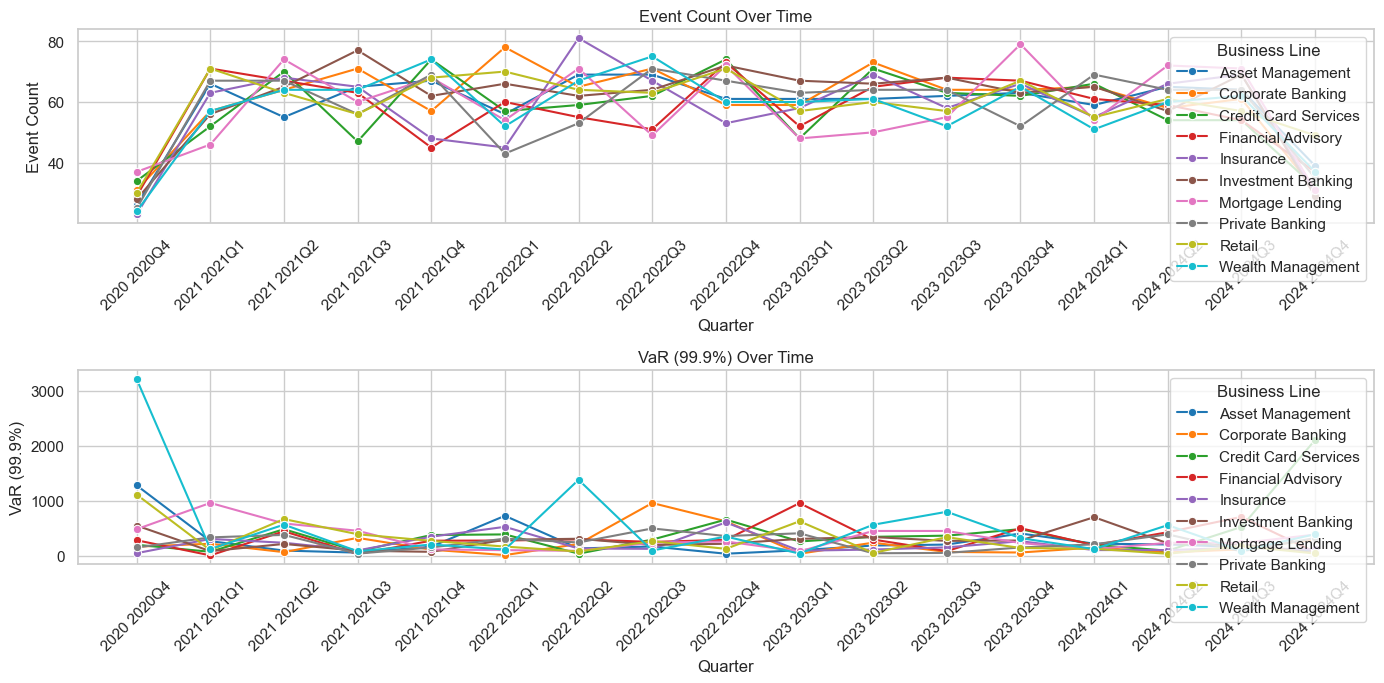

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the seaborn style
sns.set(style="whitegrid")

# Convert 'Year' and 'Quarter' to a string for easier plotting
final_agg['Quarter_Str'] = final_agg['Year'].astype(str) + ' ' + final_agg['Quarter'].astype(str)

# Plot Event Count over time
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
sns.lineplot(x='Quarter_Str', y='Event_Count', hue='Business Line', data=final_agg, marker='o', palette='tab10')
plt.title('Event Count Over Time')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Event Count')

# Plot VaR (99.9%) over time
plt.subplot(2, 1, 2)
sns.lineplot(x='Quarter_Str', y='VaR_99_9', hue='Business Line', data=final_agg, marker='o', palette='tab10')
plt.title('VaR (99.9%) Over Time')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('VaR (99.9%)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\2263360066.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Business Line', y='Event_Count', data=q4_2024_data, palette='tab10')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_8368\2263360066.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Business Line', y='VaR_99_9', data=q4_2024_data, palette='tab10')


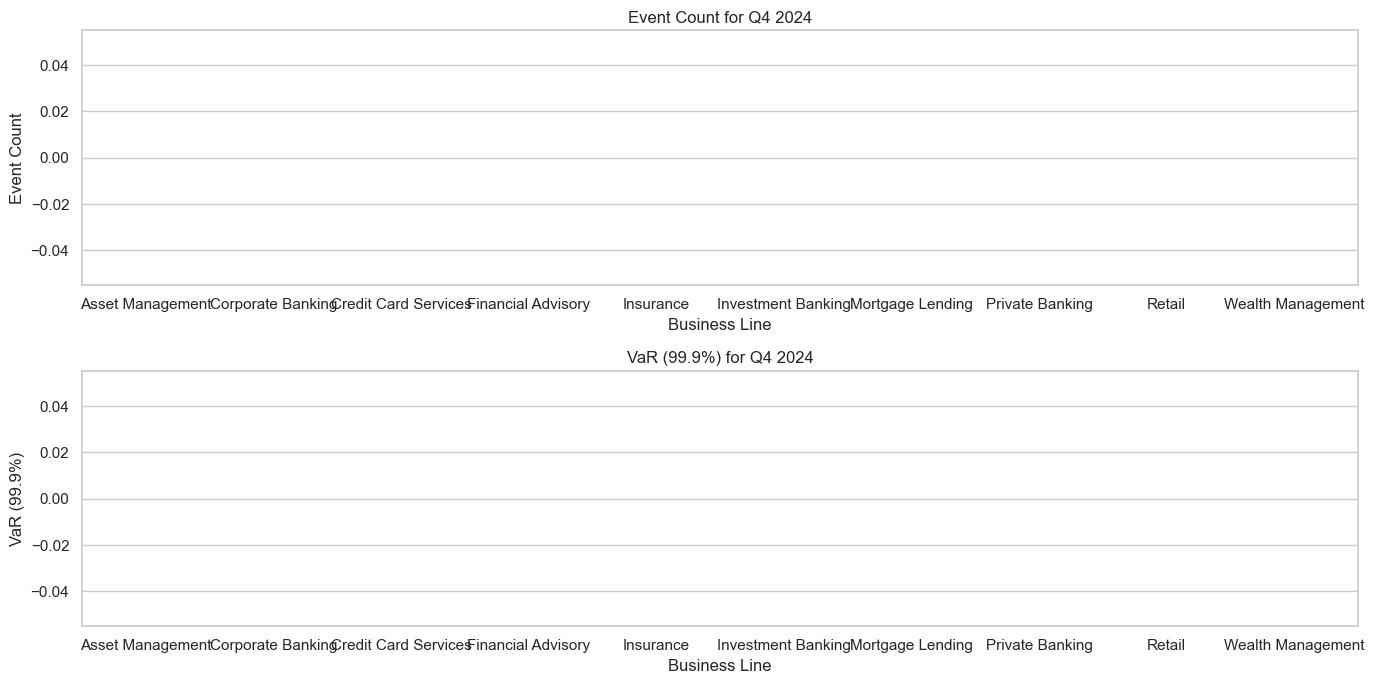

In [53]:
# Filter for Q4 2024
q4_2024_data = final_agg[final_agg['Quarter'] == '2024Q4']

# Plot Event Count for Q4 2024
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
sns.barplot(x='Business Line', y='Event_Count', data=q4_2024_data, palette='tab10')
plt.title('Event Count for Q4 2024')
plt.xlabel('Business Line')
plt.ylabel('Event Count')

# Plot VaR (99.9%) for Q4 2024
plt.subplot(2, 1, 2)
sns.barplot(x='Business Line', y='VaR_99_9', data=q4_2024_data, palette='tab10')
plt.title('VaR (99.9%) for Q4 2024')
plt.xlabel('Business Line')
plt.ylabel('VaR (99.9%)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, lognorm

# Assuming the 'final_agg' DataFrame has columns: 'Business Line', 'Event Count', 'Total Loss Amount'

# Function to generate synthetic data based on frequency and severity
def monte_carlo_simulation(business_line, freq_mean, severity_params, num_simulations=10000, confidence_level=0.999):
    # Frequency: Poisson distribution (events per period)
    frequency_samples = poisson.rvs(mu=freq_mean, size=num_simulations)
    
    # Severity: Lognormal distribution (loss per event)
    severity_samples = lognorm.rvs(sigma=severity_params[0], scale=np.exp(severity_params[1]), size=num_simulations)
    
    # Calculate total losses per simulation
    total_losses = frequency_samples * severity_samples
    
    # Calculate VaR at the given confidence level
    var_at_confidence = np.percentile(total_losses, (1 - confidence_level) * 100)
    
    return frequency_samples, severity_samples, total_losses, var_at_confidence

# Function to aggregate data and apply Monte Carlo simulation for each business line
def simulate_lda(final_agg, num_simulations=10000, confidence_level=0.999):
    results = []
    
    # Loop over each business line
    for business_line in final_agg['Business Line'].unique():
        # Filter the data for the current business line
        business_data = final_agg[final_agg['Business Line'] == business_line]
        
        # Frequency: mean event count (Poisson)
        freq_mean = business_data['Event_Count'].mean()
        
        # Severity: Fit Lognormal distribution to 'Net Loss Amount' data
        severity_params = np.log(business_data['Total_Loss_Amount'][business_data['Total_Loss_Amount'] > 0]).agg(['std', 'mean'])
        
        # Apply Monte Carlo simulation
        freq_samples, sev_samples, total_losses, var_at_confidence = monte_carlo_simulation(
            business_line, freq_mean, severity_params, num_simulations, confidence_level)
        
        # Store the results
        results.append({
            'Business Line': business_line,
            'Simulated_Frequency': np.mean(freq_samples),
            'Simulated_Severity': np.mean(sev_samples),
            'Simulated_VaR_99_9': var_at_confidence
        })
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run the simulation for LDA and Monte Carlo for 2024Q4
q4_2024_data = final_agg[final_agg['Quarter'] == '2024Q4']
lda_results = simulate_lda(q4_2024_data)

# Plot the results for Q4 2024
plt.figure(figsize=(14, 7))

# Plot the simulated VaR for each business line
sns.barplot(x='Business Line', y='Simulated_VaR_99_9', data=lda_results, palette='tab10')
plt.title('Simulated VaR (99.9%) for Q4 2024 Using Monte Carlo LDA')
plt.xlabel('Business Line')
plt.ylabel('Simulated VaR (99.9%)')

plt.tight_layout()
plt.show()


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.poisson` documentation for details.